
# Trabalho de Sistemas Inteligentes para a Bioinformática

Trabalho realizado no âmbito da unidade curricular de Sistemas Inteligentes para a Bioinformática.

Grupo constituído por:

    - Angelina Eiras PG42861
    - Carina Gonçalves PG45466
    - Rute Castro PG45475
    - Sónia Carvalho PG42882


# A alterar:

    - Poucos descritores: gerar mais com o propythia
    - Separar o x do y antes de fazer standardscaler e usar o y sem alterar os valores 
    - Retirar valores de pH maiores que 14
    - Fazer análise com base na literatura, exemplo, ponto em que a termoestabilidade representa a estabilidade etc
    - Aumentar número de features, 
    - não e preciso normalizar (podemos fazer scale e apenas no X), 
    - machine learning com regressão (tm variável continua)

Para a utilização deste notebook é necessário proceder às seguintes instalações:

In [1]:
# pip install git+https://github.com/jcapels/propythia.git@fix_dependencies
#ou download do ficheiro em formato zip
# pip install --upgrade pip
# pip install propythia-fix_dependencies.zip
# pip install -r requirements.txt

In [4]:
import pandas as pd
import scipy.cluster.hierarchy
import seaborn as sn
import numpy as np
from tensorflow import keras
from keras.optimizers.schedules import *
from propythia import *
from scipy import stats
from statsmodels.stats.weightstats import ztest as ztest
import statsmodels.api as statsmodels
import matplotlib.pyplot as plt
%matplotlib inline

import re
import random
import requests as r
from Bio import SeqIO
from io import StringIO
from collections import Counter
import seaborn as sns

from propythia.protein_descriptores import ProteinDescritors

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2, f_classif, SelectPercentile, r_regression
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, matthews_corrcoef, f1_score, roc_auc_score, log_loss, hinge_loss, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, LeaveOneOut
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.stats import uniform, shapiro, levene, mannwhitneyu, ttest_ind
from scipy.cluster.hierarchy import dendrogram, linkage 

from sklearn.datasets import load_iris

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt

------------------------------------------------------------------------------------------------------------------------------------------------------

#  Fase 1 

## Exploração inicial

Nesta secção são apresentados os dados provenientes do desafio Kaggle (https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction). Os datasets abordam o tema de enzimas que são proteínas que atuam como catalisadores nas reações químicas dos organismos vivos.
O objetivo do trabalho é prever a termoestabilidade de variantes enzimáticas, uma vez que compreender e prever com precisão a estabilidade da proteína é um problema fundamental na biotecnologia. Melhorias na estabilidade da enzima podem reduzir os custos e aumentar a velocidade que os cientistas podem iterar nos conceitos.
Os dados de termoestabilidade (temperatura de fusão) foram medidos experimentalmente e incluem sequências naturais, bem como sequências modificadas com mutações únicas ou múltiplas nas sequências naturais.


## Pré-processamento

Os primeiros passos tomados vão juntar os datasets provenientes do desafio - `train` e `train_update`, e juntá-los numa única DataFrame.
De seguida, vamos extender os dados existentes com descritores físico-químicos obtidos com o Propythia, desenvolvido na Universidade do Minho, que vão ser utilizados para o resto do trabalho.

In [184]:
# Ler os datasets provenientes do desafio
train = pd.read_csv('datasets/train_nanFREE.csv', delimiter = ',')
updates = pd.read_csv('datasets/train_updates_20220929.csv', delimiter = ',')
print(train.shape)
train.head()

(28723, 5)


,Unnamed: 0,seq_id,protein_sequence,pH,tm
0,0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


In [185]:
print(updates.shape)
updates.head()

(2434, 5)


,seq_id,protein_sequence,pH,data_source,tm
0,69,NaN,NaN,NaN,NaN
1,70,NaN,NaN,NaN,NaN
2,71,NaN,NaN,NaN,NaN
3,72,NaN,NaN,NaN,NaN
4,73,NaN,NaN,NaN,NaN


In [186]:
# Colunas para atualizar no dataset de treino
col_to_update = ['protein_sequence', 'pH', 'tm']

# Atualizar o seq_id
to_update_id = list(updates[~updates.protein_sequence.isna()].seq_id)

# Fazer o update só nas linhas que são necessarias
updates = updates[updates.seq_id.isin(to_update_id)].set_index('seq_id')

# Atualizar os valores no dataset de treino
train.loc[to_update_id, col_to_update] = updates[col_to_update].values

# Verificar se está com os updates
pd.concat([train[train.seq_id.isin(to_update_id)].set_index('seq_id'), updates], axis = 1)

#nao precisamos dos links - drop do data_source
#train.drop(['data_source'], axis=1, inplace=True)

# Retirar os pHs maiores que 14
train = train[train["pH"]<=14] 

print(train.shape)
train.head()

(28723, 5)


,Unnamed: 0,seq_id,protein_sequence,pH,tm
0,0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


### Gerar descritores

Dos métodos disponíveis na classe `ProteinDescriptors`, faz sentido utilizar cinco destes pelos seguintes motivos:
-  `get_all_aac()`: explicar o que faz e o porquê de se querer usar - vai calcular o "A B C" da sequência...
-  `get_all_physicochemical()`: explicar o que faz e o porquê de se querer usar
-  `get_all_base_class()`: explicar o que faz e o porquê de se querer usar
-  `get_all_sequenceorder()`: explicar o que faz e o porquê de se querer usar
-  `get_all_correlation()`: explicar o que faz e o porquê de se querer usar

Foi também testada a possibilidade de utilizar o `get_all()`, que também englobaria estes, mas o peso computacional deste método era demasiado grande.
Por questões de performance - e por forma a salvaguardar o progresso, cada um dos métodos mencionados é calculado individualmente e guardado em ficheiros dedicados, os quais são agregados à posteriori.

In [32]:
# Calcular toda a informação extra
print("running get_all_aac")
result_all_aac : pd.DataFrame = ProteinDescritors(dataset=train, col='protein_sequence').get_all_aac(n_jobs=96)
result_all_aac.to_csv('datasets/get_all_aac.csv')

print("running get_all_physicochemical")
result_all_physicochemical : pd.DataFrame = ProteinDescritors(dataset=train, col='protein_sequence').get_all_physicochemical(n_jobs=96)
result_all_physicochemical.to_csv('datasets/get_all_physicochemical.csv')

print("running get_all_base_class")
result_all_base_class : pd.DataFrame = ProteinDescritors(dataset=train, col='protein_sequence').get_all_base_class(window=5, n_jobs=96)
result_all_base_class.to_csv('datasets/get_all_base_class.csv')

print("running get_all_sequenceorder")
result_all_sequenceorder : pd.DataFrame = ProteinDescritors(dataset=train, col='protein_sequence').get_all_sequenceorder(maxlag_socn=5,maxlag_qso=5, n_jobs=96) # Falhou
result_all_sequenceorder.to_csv('datasets/get_all_sequenceorder.csv')

print("running get_all_correlation")
result_all_correlation : pd.DataFrame = ProteinDescritors(dataset=train, col='protein_sequence').get_all_correlation(n_jobs=96)
result_all_correlation.to_csv('datasets/get_all_correlation.csv')

running get_all_aac
running get_all_physicochemical
running get_all_base_class
running get_all_sequenceorder
running get_all_correlation
merging
dumping


In [25]:
# Junção dos resultados num único dataset - all_descriptors.csv
datasets = [
   'datasets/get_all_physicochemical.csv',
   'datasets/get_all_sequenceorder.csv',
   'datasets/get_all_correlation.csv',
   'datasets/get_all_base_class.csv',
   'datasets/get_all_aac.csv'
   ]

dataset = pd.DataFrame()
for dataset in datasets:
   dataset = pd.read_csv(dataset, delimiter = ',')
   dataset = dataset if dataset.empty else dataset.merge(dataset, how='inner', on = "protein_sequence", validate="one_to_one")
# dataset = dataset.loc[:,~dataset.columns.duplicated()] # remove duplicates não funciona porque o join() mete sufixos quando os nomes são iguais

print("dumping")
dataset.to_csv('datasets/all_descriptors.csv') 

print(dataset.shape)
dataset.head()

C:\Users\SOA5BRG\AppData\Local\Temp\ipykernel_17520\2114072168.py:13: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0.1_x', 'tm_x', 'Unnamed: 0_x', 'pH_x', 'seq_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  descriptors_df = dataframe if descriptors_df.empty else descriptors_df.merge(dataframe, how='inner', on = "protein_sequence", validate="one_to_one")


dumping
(28701, 9270)


,Unnamed: 0.1_x,Unnamed: 0_x,seq_id_x,protein_sequence,pH_x,tm_x,length,charge,chargedensity,formulaC,...,VVL,VVK,VVM,VVF,VVP,VVS,VVT,VVW,VVY,VVV
0,0,0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341.0,-1.732,-0.000048,1622,...,0,1,0,0,0,0,1,0,0,0
1,1,1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286.0,-12.537,-0.000382,1385,...,1,0,0,0,0,0,0,0,0,0
2,2,2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497.0,11.513,0.000215,2290,...,0,0,0,0,0,0,0,0,0,0
3,3,3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265.0,-20.606,-0.000699,1293,...,0,0,0,0,0,0,0,0,0,0
4,4,4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451.0,-21.900,-0.000138,6948,...,0,0,0,0,1,3,0,0,0,2


### Pré-limpeza dos dados
Com o merge dos resultados do ProteinDescriptors, foram introduzidos alguns artefactos no dataset, nomeadamente colunas duplicadas, marcadas com `_x`, `_y`, entre outros.
Antes de proceder à análise dos dados, faz sentido remover estas para facilitar o processamento e a interpretação.

In [5]:
# load dataset after processing
dataset = pd.read_csv('datasets/all_descriptors.csv', delimiter = ',')
print(dataset.shape, dataset.dtypes)
dataset.describe()
# As variáveis têm valores em gamas muito diferentes, vai ser preciso fazer normalização dos dados
# Há também colunas duplicadas  resultantes do merge(), que ficaram com sufixos _x e _y, outras que são Unnamed.
# A coluna seq_id tem mais valores que o indicado pela shape

(28701, 9271) Unnamed: 0.2         int64
Unnamed: 0.1_x       int64
Unnamed: 0_x         int64
seq_id_x             int64
protein_sequence    object
                     ...  
VVS                  int64
VVT                  int64
VVW                  int64
VVY                  int64
VVV                  int64
Length: 9271, dtype: object


,Unnamed: 0.2,Unnamed: 0.1_x,Unnamed: 0_x,seq_id_x,pH_x,tm_x,length,charge,chargedensity,formulaC,...,VVL,VVK,VVM,VVF,VVP,VVS,VVT,VVW,VVY,VVV
count,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,...,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000
mean,14350.000000,14350.000000,15551.295878,15551.295878,6.939714,49.366046,468.942197,-5.373652,-0.000061,2296.848925,...,0.170865,0.128393,0.041741,0.075990,0.109717,0.173374,0.128114,0.020975,0.055294,0.160587
std,8285.409374,8285.409374,9222.759275,9222.759275,0.618851,13.722043,663.358958,19.323826,0.000334,3240.829212,...,0.457690,0.470298,0.219756,0.293677,0.463418,0.516936,0.491245,0.231144,0.244326,0.444982
min,0.000000,0.000000,0.000000,0.000000,1.990000,0.000000,5.000000,-903.437000,-0.002708,22.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7175.000000,7175.000000,7450.000000,7450.000000,7.000000,42.300000,219.000000,-9.834000,-0.000232,1086.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14350.000000,14350.000000,15190.000000,15190.000000,7.000000,48.000000,356.000000,-3.336000,-0.000082,1750.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21525.000000,21525.000000,23711.000000,23711.000000,7.000000,53.500000,545.000000,3.029000,0.000086,2688.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,28700.000000,28700.000000,31389.000000,31389.000000,11.000000,130.000000,32767.000000,396.696000,0.002890,161074.000000,...,7.000000,19.000000,5.000000,5.000000,20.000000,13.000000,20.000000,12.000000,3.000000,11.000000


In [8]:
# Remove colunas que contém "Unnamed" no início, chamam-se '_', ou têm sufixo indicativo de duplicado
dataset = dataset.loc[:, ~dataset.columns.str.contains('^Unnamed')]
dataset = dataset.loc[:, ~dataset.columns.str.fullmatch('_')]
# find duplicate column names (from merge) and remove them
# seq_id_x.1  tm_x.1  seq_id_y.1  tm_y.1
for col in filter(lambda x:x.endswith('_y'), dataset.columns):
    dataset = dataset.drop(col, axis=1)
for col in filter(lambda x:x.endswith('_x'), dataset.columns):
    dataset = dataset.rename(columns={col:col[-2]})
for col in filter(lambda x:'0'<=x[-1]<='9' and x[-2]=='.', dataset.columns):
    dataset = dataset.drop(col, axis=1)


In [9]:
for col in dataset.columns:
    if col.startswith("Unnamed") or col.startswith("_") or col.endswith("_x") or col.endswith("_y") or "0"<=col[0]<"9":
        print(col)
# é necessário _recorrer_ a anterior e esta

In [10]:
# Confirmar que não há dados omissos
# dataset.isnull().sum().sum()
set(dataset.isnull().sum())
# Só há valores 0, o que indica que todas as colunas tem 0 valores omissos

{0}

In [11]:
# Eliminar linhas duplicadas, drop das duas colunas para ser possível fazer o pre porcessamento dos dados
# Isto faz sentido porque já extraímos a informação da sequência (features vindas do ProteinDescriptors)
dataset_dropped = dataset.drop_duplicates(subset = "seq_id")
dataset_dropped = dataset_dropped.drop(columns=['seq_id', 'protein_sequence'], axis=1)
dataset_dropped.shape

(28701, 9246)

### Análise exploratória inicial
Para analisar os dados vamos começar por estudar algumas propriedades estatísticas das features no dataset, dando assim um entendimento de como os valores estão distribuídos, e da sua variância.

In [12]:
dataset.describe()

,length,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,formulaS,tot,hydrogen,...,VVL,VVK,VVM,VVF,VVP,VVS,VVT,VVW,VVY,VVV
count,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.0,28701.0,...,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000
mean,468.942197,-5.373652,-0.000061,2296.848925,3603.084945,619.323403,724.173722,17.669628,0.0,0.0,...,0.170865,0.128393,0.041741,0.075990,0.109717,0.173374,0.128114,0.020975,0.055294,0.160587
std,663.358958,19.323826,0.000334,3240.829212,5117.825509,868.292488,1037.634028,22.715777,0.0,0.0,...,0.457690,0.470298,0.219756,0.293677,0.463418,0.516936,0.491245,0.231144,0.244326,0.444982
min,5.000000,-903.437000,-0.002708,22.000000,40.000000,8.000000,7.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,219.000000,-9.834000,-0.000232,1086.000000,1700.000000,290.000000,334.000000,7.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,356.000000,-3.336000,-0.000082,1750.000000,2743.000000,469.000000,540.000000,13.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,545.000000,3.029000,0.000086,2688.000000,4187.000000,719.000000,834.000000,21.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,32767.000000,396.696000,0.002890,161074.000000,255327.000000,42607.000000,50595.000000,865.000000,0.0,0.0,...,7.000000,19.000000,5.000000,5.000000,20.000000,13.000000,20.000000,12.000000,3.000000,11.000000



A primeira conclusão que podemos tomar é de que há um número muito grande de features no dataset, pelo que faz sentido verificar se podemos reduzir a dimensão aplicando uma simples threshold à variância dos dados.

In [13]:
# depois de termos o dataset limpo e só com variáveis num
vt = VarianceThreshold(threshold=0.5)
#dataset = dataset.select_dtypes(include='number')

# Fit e obter a mask binária
mask = vt.fit(dataset_dropped).get_support(indices=False)
dataset = dataset_dropped.loc[:, mask]
binary_cols= [col for col in dataset.columns if len(dataset[col].unique())==2]
print("Binary columns:", binary_cols)
dataset.describe()

Binary columns: []


,length,charge,formulaC,formulaH,formulaN,formulaO,formulaS,MW_modlamp,IsoelectricPoint,Instability_index,...,TGL,TTT,TVT,VEK,VLD,VLE,VKE,VPE,VSA,VTG
count,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,2.870100e+04,28701.000000,28701.000000,...,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000
mean,468.942197,-5.373652,2296.848925,3603.084945,619.323403,724.173722,17.669628,5.231206e+04,6.754963,40.477556,...,0.159263,0.116128,0.128950,0.195150,0.181178,0.219609,0.168879,0.138114,0.175987,0.149995
std,663.358958,19.323826,3240.829212,5117.825509,868.292488,1037.634028,22.715777,7.380937e+04,1.692092,11.358696,...,0.770063,0.714995,0.917878,0.851397,0.746790,0.718904,0.736610,1.331978,0.737452,0.907485
min,5.000000,-903.437000,22.000000,40.000000,8.000000,7.000000,0.000000,5.276200e+02,4.050028,-7.383333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,219.000000,-9.834000,1086.000000,1700.000000,290.000000,334.000000,7.000000,2.457427e+04,5.407628,33.351489,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,356.000000,-3.336000,1750.000000,2743.000000,469.000000,540.000000,13.000000,3.955597e+04,6.149945,39.656029,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,545.000000,3.029000,2688.000000,4187.000000,719.000000,834.000000,21.000000,6.076843e+04,8.412367,46.765722,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,32767.000000,396.696000,161074.000000,255327.000000,42607.000000,50595.000000,865.000000,3.637297e+06,11.999968,141.642748,...,39.000000,82.000000,51.000000,46.000000,38.000000,32.000000,38.000000,82.000000,37.000000,51.000000


Com uma threhsold de 0.5, um valor bastante baixo, foi possível reduzir a dimensão de 9247 para 125, uma redução para cerca de 98% no número de features, com pouca perda de informação. Também se constata que não existem colunas que possam ser interpretadas como sendo binárias, i.e. apenas dois valores admissíveis.

Analise-se agora a distribuição dos valores de cada feature:

array([[<AxesSubplot: title={'center': 'length'}>,
        <AxesSubplot: title={'center': 'charge'}>,
        <AxesSubplot: title={'center': 'formulaC'}>,
        <AxesSubplot: title={'center': 'formulaH'}>,
        <AxesSubplot: title={'center': 'formulaN'}>,
        <AxesSubplot: title={'center': 'formulaO'}>,
        <AxesSubplot: title={'center': 'formulaS'}>,
        <AxesSubplot: title={'center': 'MW_modlamp'}>,
        <AxesSubplot: title={'center': 'IsoelectricPoint'}>,
        <AxesSubplot: title={'center': 'Instability_index'}>,
        <AxesSubplot: title={'center': 'Molar_extinction_coefficient_reduced'}>],
       [<AxesSubplot: title={'center': 'Molar_extinction_coefficient_oxidized'}>,
        <AxesSubplot: title={'center': 'aliphatic_index'}>,
        <AxesSubplot: title={'center': 'tausw1'}>,
        <AxesSubplot: title={'center': 'tausw2'}>,
        <AxesSubplot: title={'center': 'tausw3'}>,
        <AxesSubplot: title={'center': 'tausw4'}>,
        <AxesSubplot: title

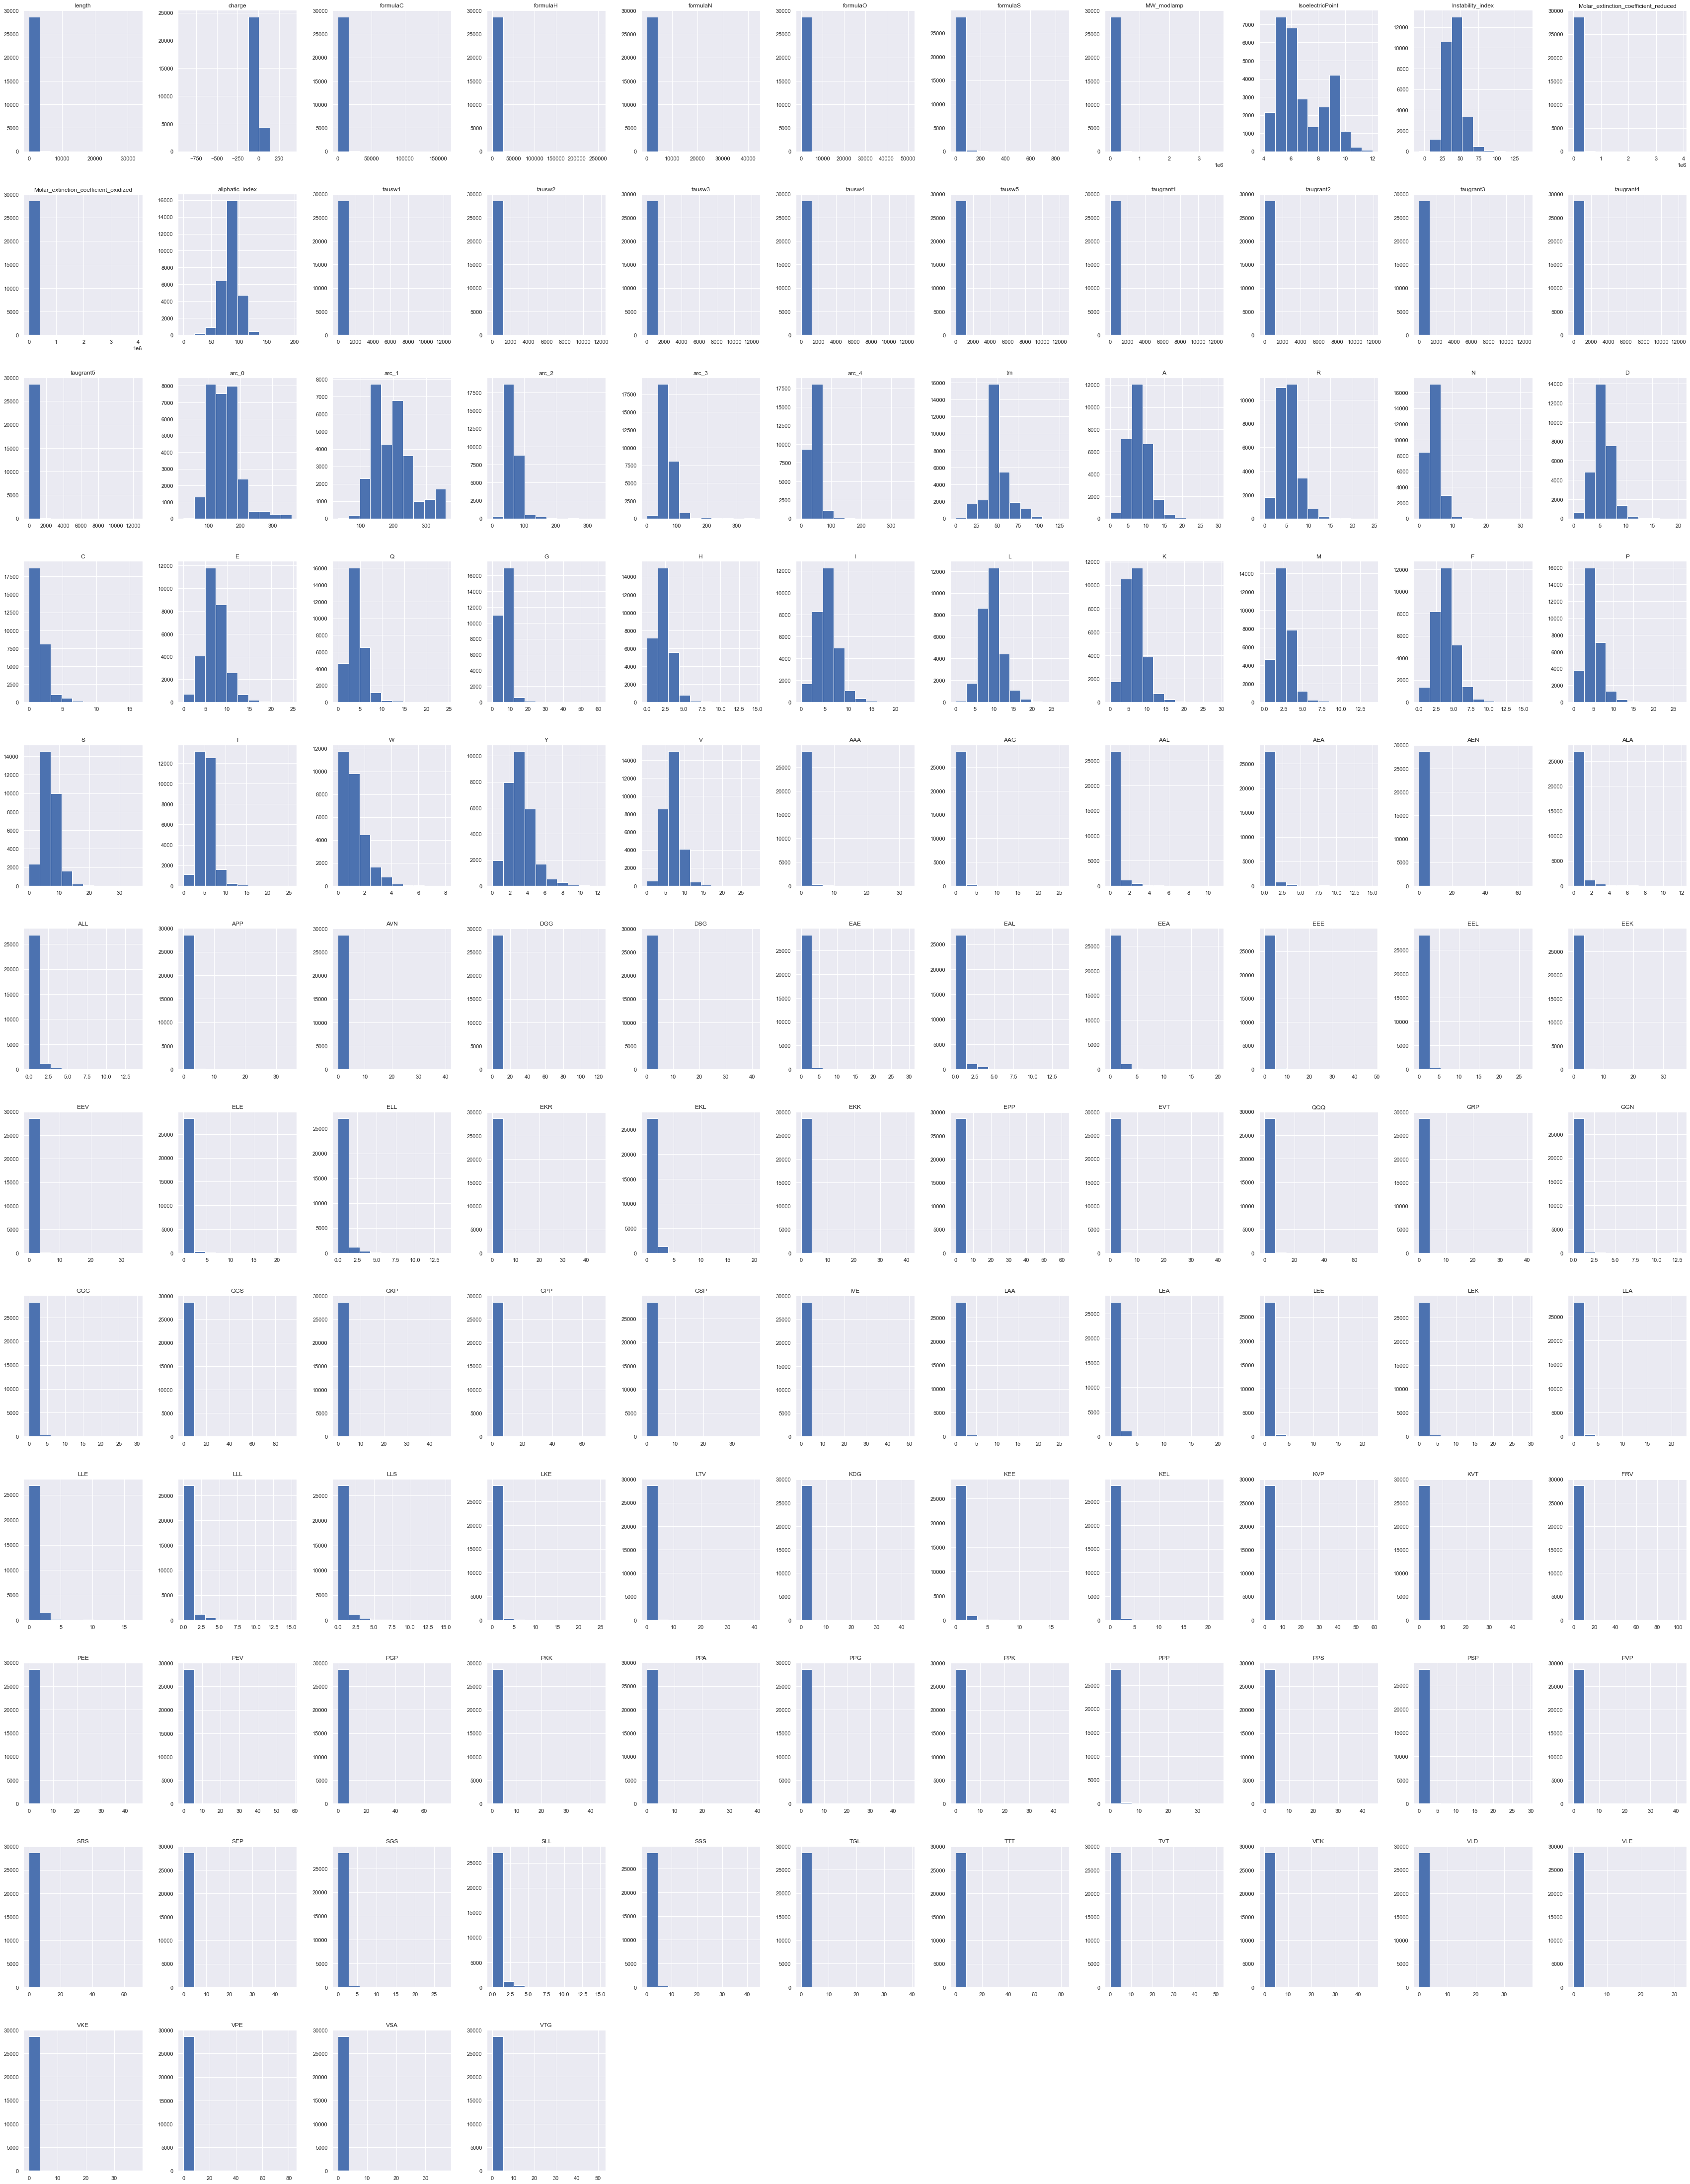

In [16]:
dataset.hist(figsize=(60,80))

Como mostra a figura, a maior parte das features tem distribuições muito distintas umas das outras, nomeadamente `arc_4` e `A`. Por isso, faz sentido remover os outliers que possam estar a extremar as gamas de valores, e realizar uma normalização dos valores para uma escala comum, por exemplo com o `StandardScaler`.

Antes: (28701, 124) (28701, 1)
Depois: (28344, 124) (28344, 1)


array([[<AxesSubplot: title={'center': 'length'}>,
        <AxesSubplot: title={'center': 'charge'}>,
        <AxesSubplot: title={'center': 'formulaC'}>,
        <AxesSubplot: title={'center': 'formulaH'}>,
        <AxesSubplot: title={'center': 'formulaN'}>,
        <AxesSubplot: title={'center': 'formulaO'}>,
        <AxesSubplot: title={'center': 'formulaS'}>,
        <AxesSubplot: title={'center': 'MW_modlamp'}>,
        <AxesSubplot: title={'center': 'IsoelectricPoint'}>,
        <AxesSubplot: title={'center': 'Instability_index'}>,
        <AxesSubplot: title={'center': 'Molar_extinction_coefficient_reduced'}>],
       [<AxesSubplot: title={'center': 'Molar_extinction_coefficient_oxidized'}>,
        <AxesSubplot: title={'center': 'aliphatic_index'}>,
        <AxesSubplot: title={'center': 'tausw1'}>,
        <AxesSubplot: title={'center': 'tausw2'}>,
        <AxesSubplot: title={'center': 'tausw3'}>,
        <AxesSubplot: title={'center': 'tausw4'}>,
        <AxesSubplot: title

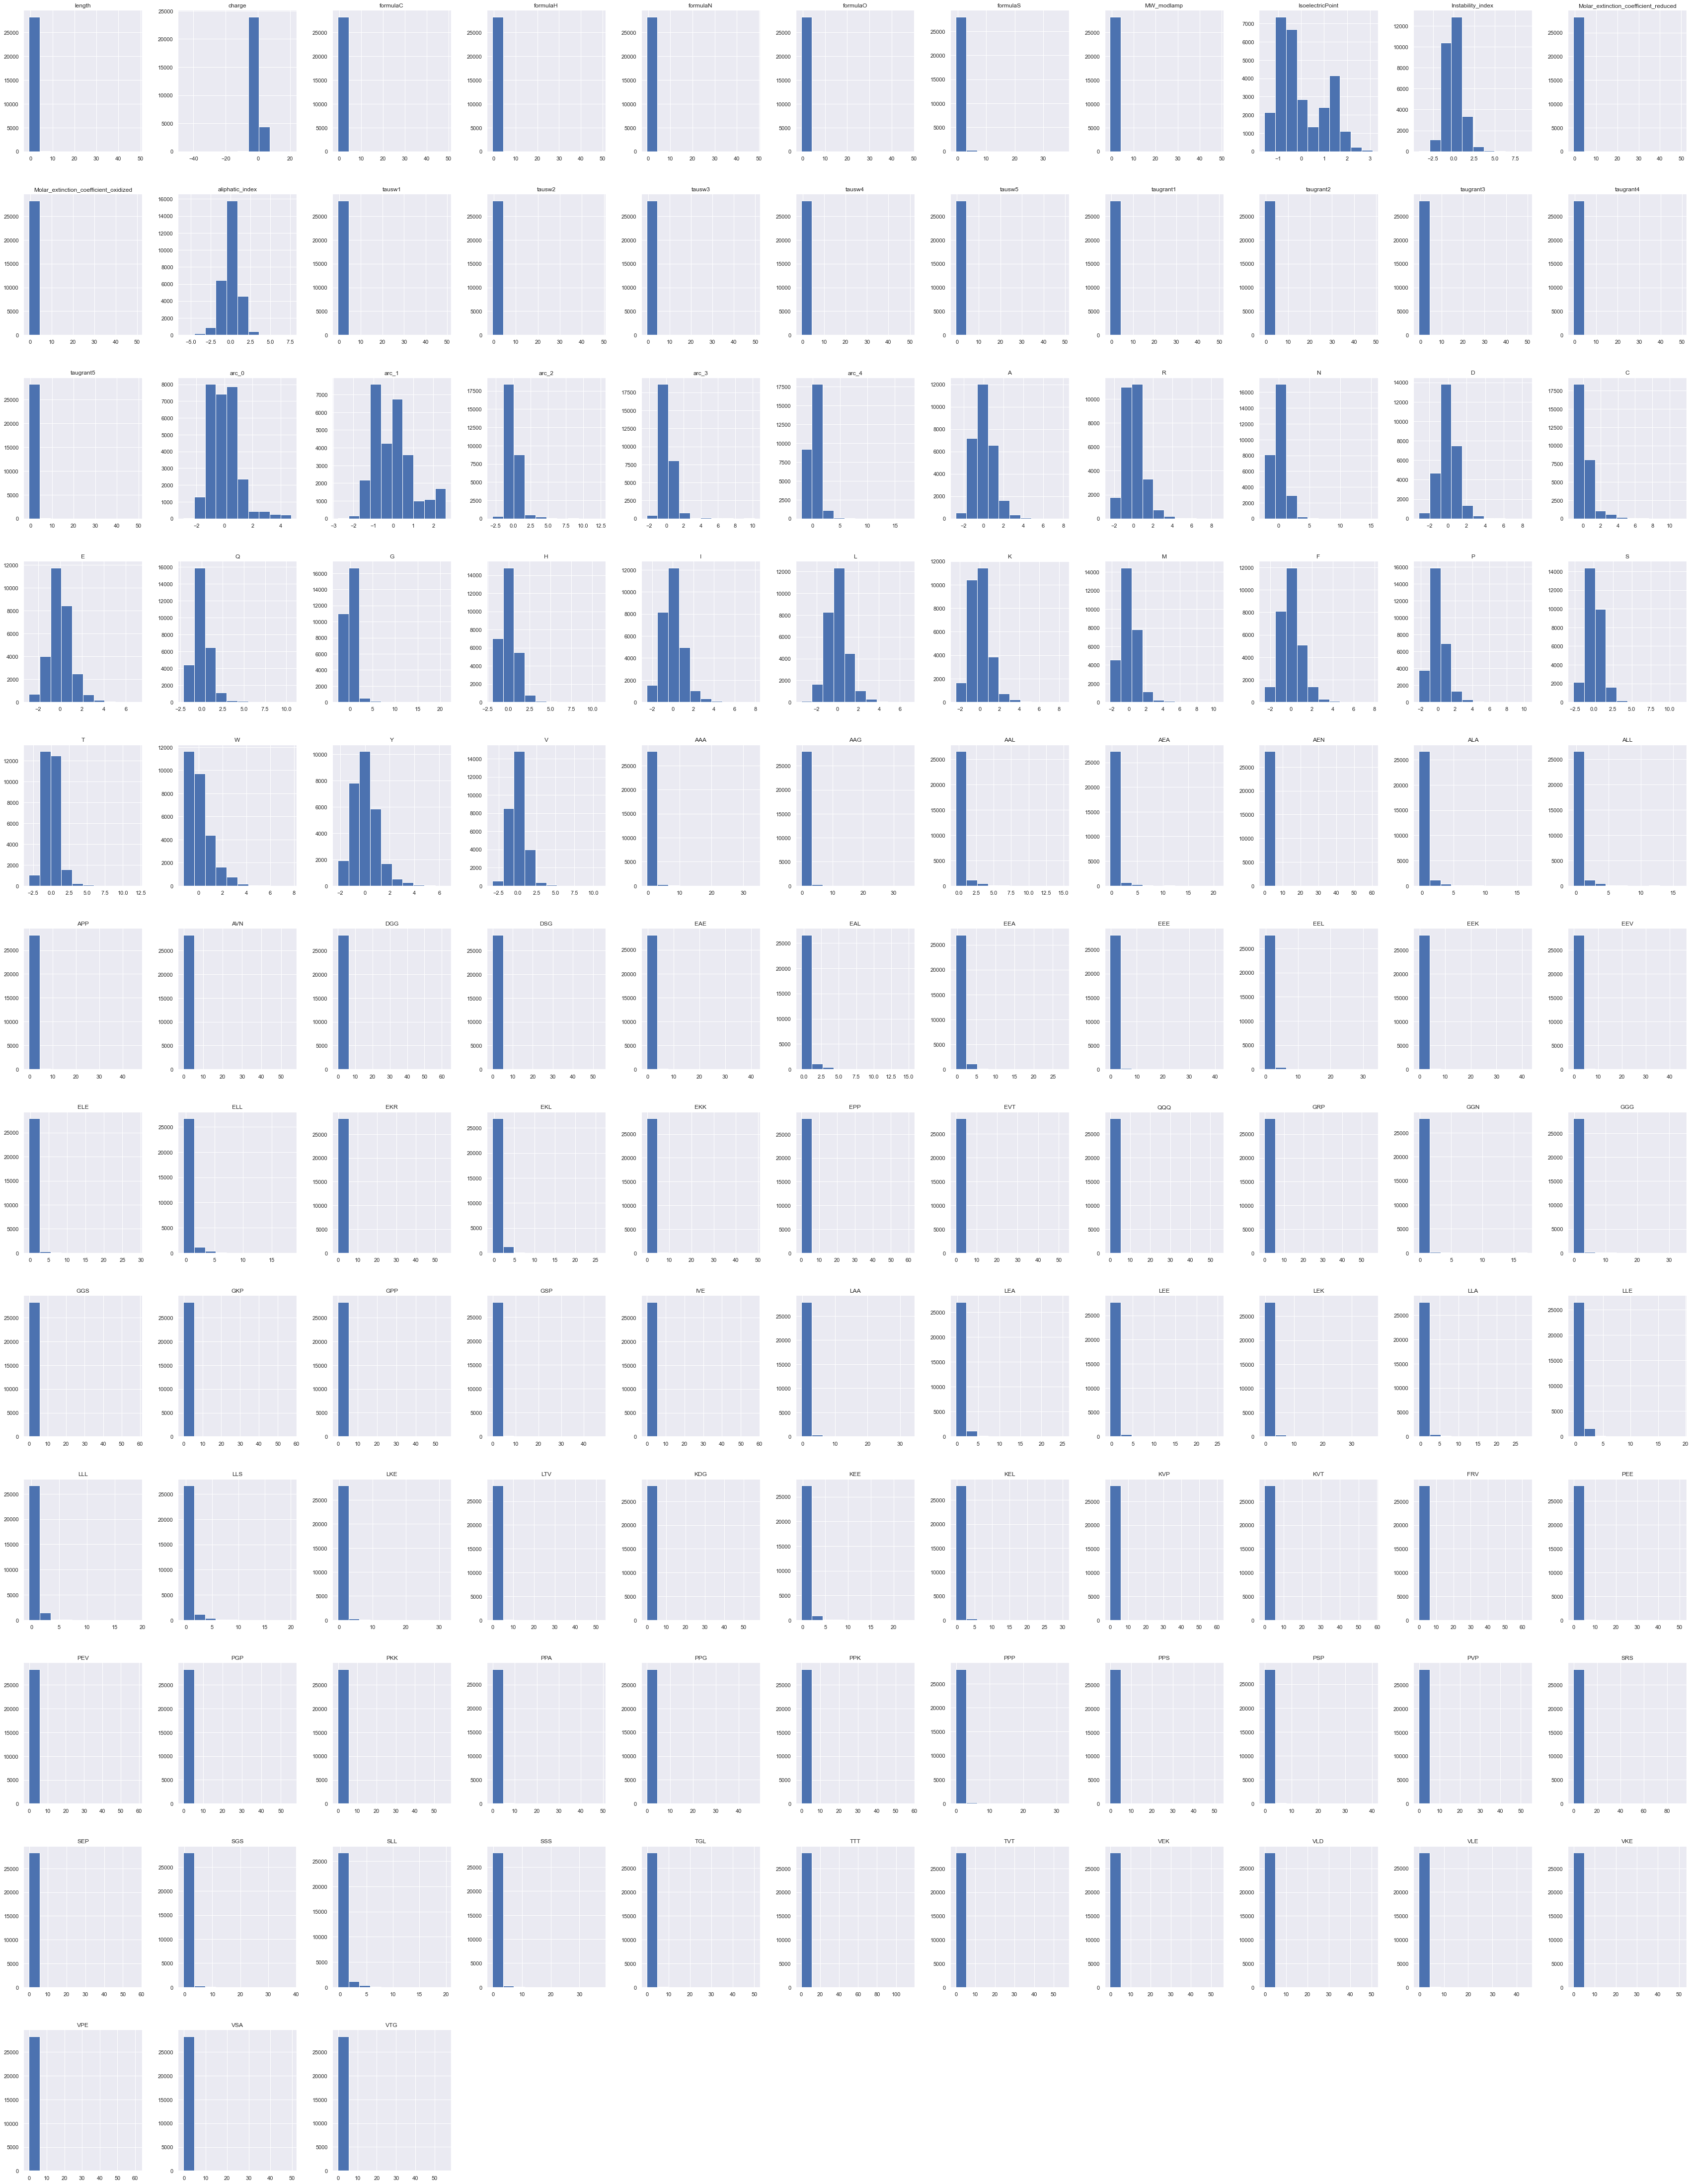

In [48]:
# Separar dados em X e Y para aplicar o scaler apenas às features
Y_dataset = dataset["tm"].to_frame(name = "tm")
X_dataset = dataset.drop("tm", axis=1)
print("Antes:", X_dataset.shape, Y_dataset.shape)

# Remoção de outliers
X_dataset = X_dataset[(np.abs(stats.zscore(dataset["tm"])) < 3)]
Y_dataset = Y_dataset[(np.abs(stats.zscore(dataset["tm"])) < 3)]
print("Depois:", X_dataset.shape, Y_dataset.shape)

# Fazer normalização dos dados de X
data = StandardScaler().fit(X_dataset)
data_st = data.transform(X_dataset)

# Sumariar os dados transformados (atenção que agora é array numpy e não panda dataframe)
np.set_printoptions(precision=3)

# Converter de novo a pandas dataframe 
data_scale = pd.DataFrame(data_st, index=X_dataset.index, columns=X_dataset.columns)

# Sumariar estatísticas
data_scale.hist(figsize=(60,80))

In [50]:
# Verificar a normalidade da termoestabilidade após StandardScaler (?)
#statsmodels.qqplot(Y_dataset, dist = stats.norm, line = '45', ax = None)

Como mostra a figura, as featores já têm os seus valores numa gama de valores muito mais semelhante, na gama das unidades e centrada em 0.

Estude-se em seguida as correlações entre as diferentes features do dataset.

In [51]:
# # Distribuição da termoestabilidade
# sn.displot(data = Y_dataset, x = 'tm', color = 'red')
# plt.xlabel('Termoestabilidade')
# plt.title('tm distribution')
# plt.show()

,length,charge,formulaC,formulaH,formulaN,formulaO,formulaS,MW_modlamp,IsoelectricPoint,Instability_index,...,TGL,TTT,TVT,VEK,VLD,VLE,VKE,VPE,VSA,VTG
length,1.000000,-0.518369,0.999465,0.999398,0.999350,0.999099,0.905650,0.999739,-0.097443,0.143693,...,0.737628,0.354938,0.770979,0.743495,0.742937,0.711486,0.742882,0.782055,0.736980,0.768369
charge,-0.518369,1.000000,-0.515359,-0.511354,-0.509255,-0.537081,-0.481836,-0.519656,0.590594,-0.048162,...,-0.332061,-0.329175,-0.377712,-0.285312,-0.328447,-0.335497,-0.330454,-0.297564,-0.302517,-0.320104
formulaC,0.999465,-0.515359,1.000000,0.999834,0.999095,0.998336,0.903878,0.999788,-0.096424,0.139884,...,0.738238,0.348670,0.771874,0.747513,0.746805,0.714816,0.745687,0.786089,0.737090,0.770373
formulaH,0.999398,-0.511354,0.999834,1.000000,0.999131,0.998262,0.902028,0.999676,-0.092675,0.139799,...,0.738810,0.347852,0.773440,0.750748,0.749018,0.717316,0.748217,0.788758,0.738938,0.771766
formulaN,0.999350,-0.509255,0.999095,0.999131,1.000000,0.998766,0.905485,0.999565,-0.087873,0.153082,...,0.731753,0.350710,0.764932,0.740908,0.741184,0.710886,0.740002,0.777428,0.731763,0.762596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VLE,0.711486,-0.335497,0.714816,0.717316,0.710886,0.706964,0.596527,0.711938,-0.066994,0.069621,...,0.581246,0.221388,0.642779,0.638333,0.630014,1.000000,0.615376,0.696231,0.594598,0.636889
VKE,0.742882,-0.330454,0.745687,0.748217,0.740002,0.738947,0.608369,0.742418,-0.055148,0.038306,...,0.679716,0.227685,0.737030,0.714657,0.676223,0.615376,1.000000,0.785157,0.684328,0.724849
VPE,0.782055,-0.297564,0.786089,0.788758,0.777428,0.772941,0.614429,0.780234,-0.027476,0.034368,...,0.772171,0.259335,0.852945,0.822335,0.779763,0.696231,0.785157,1.000000,0.769137,0.851268
VSA,0.736980,-0.302517,0.737090,0.738938,0.731763,0.729579,0.610610,0.733764,-0.030817,0.025283,...,0.686408,0.252233,0.729541,0.678896,0.656717,0.594598,0.684328,0.769137,1.000000,0.728771


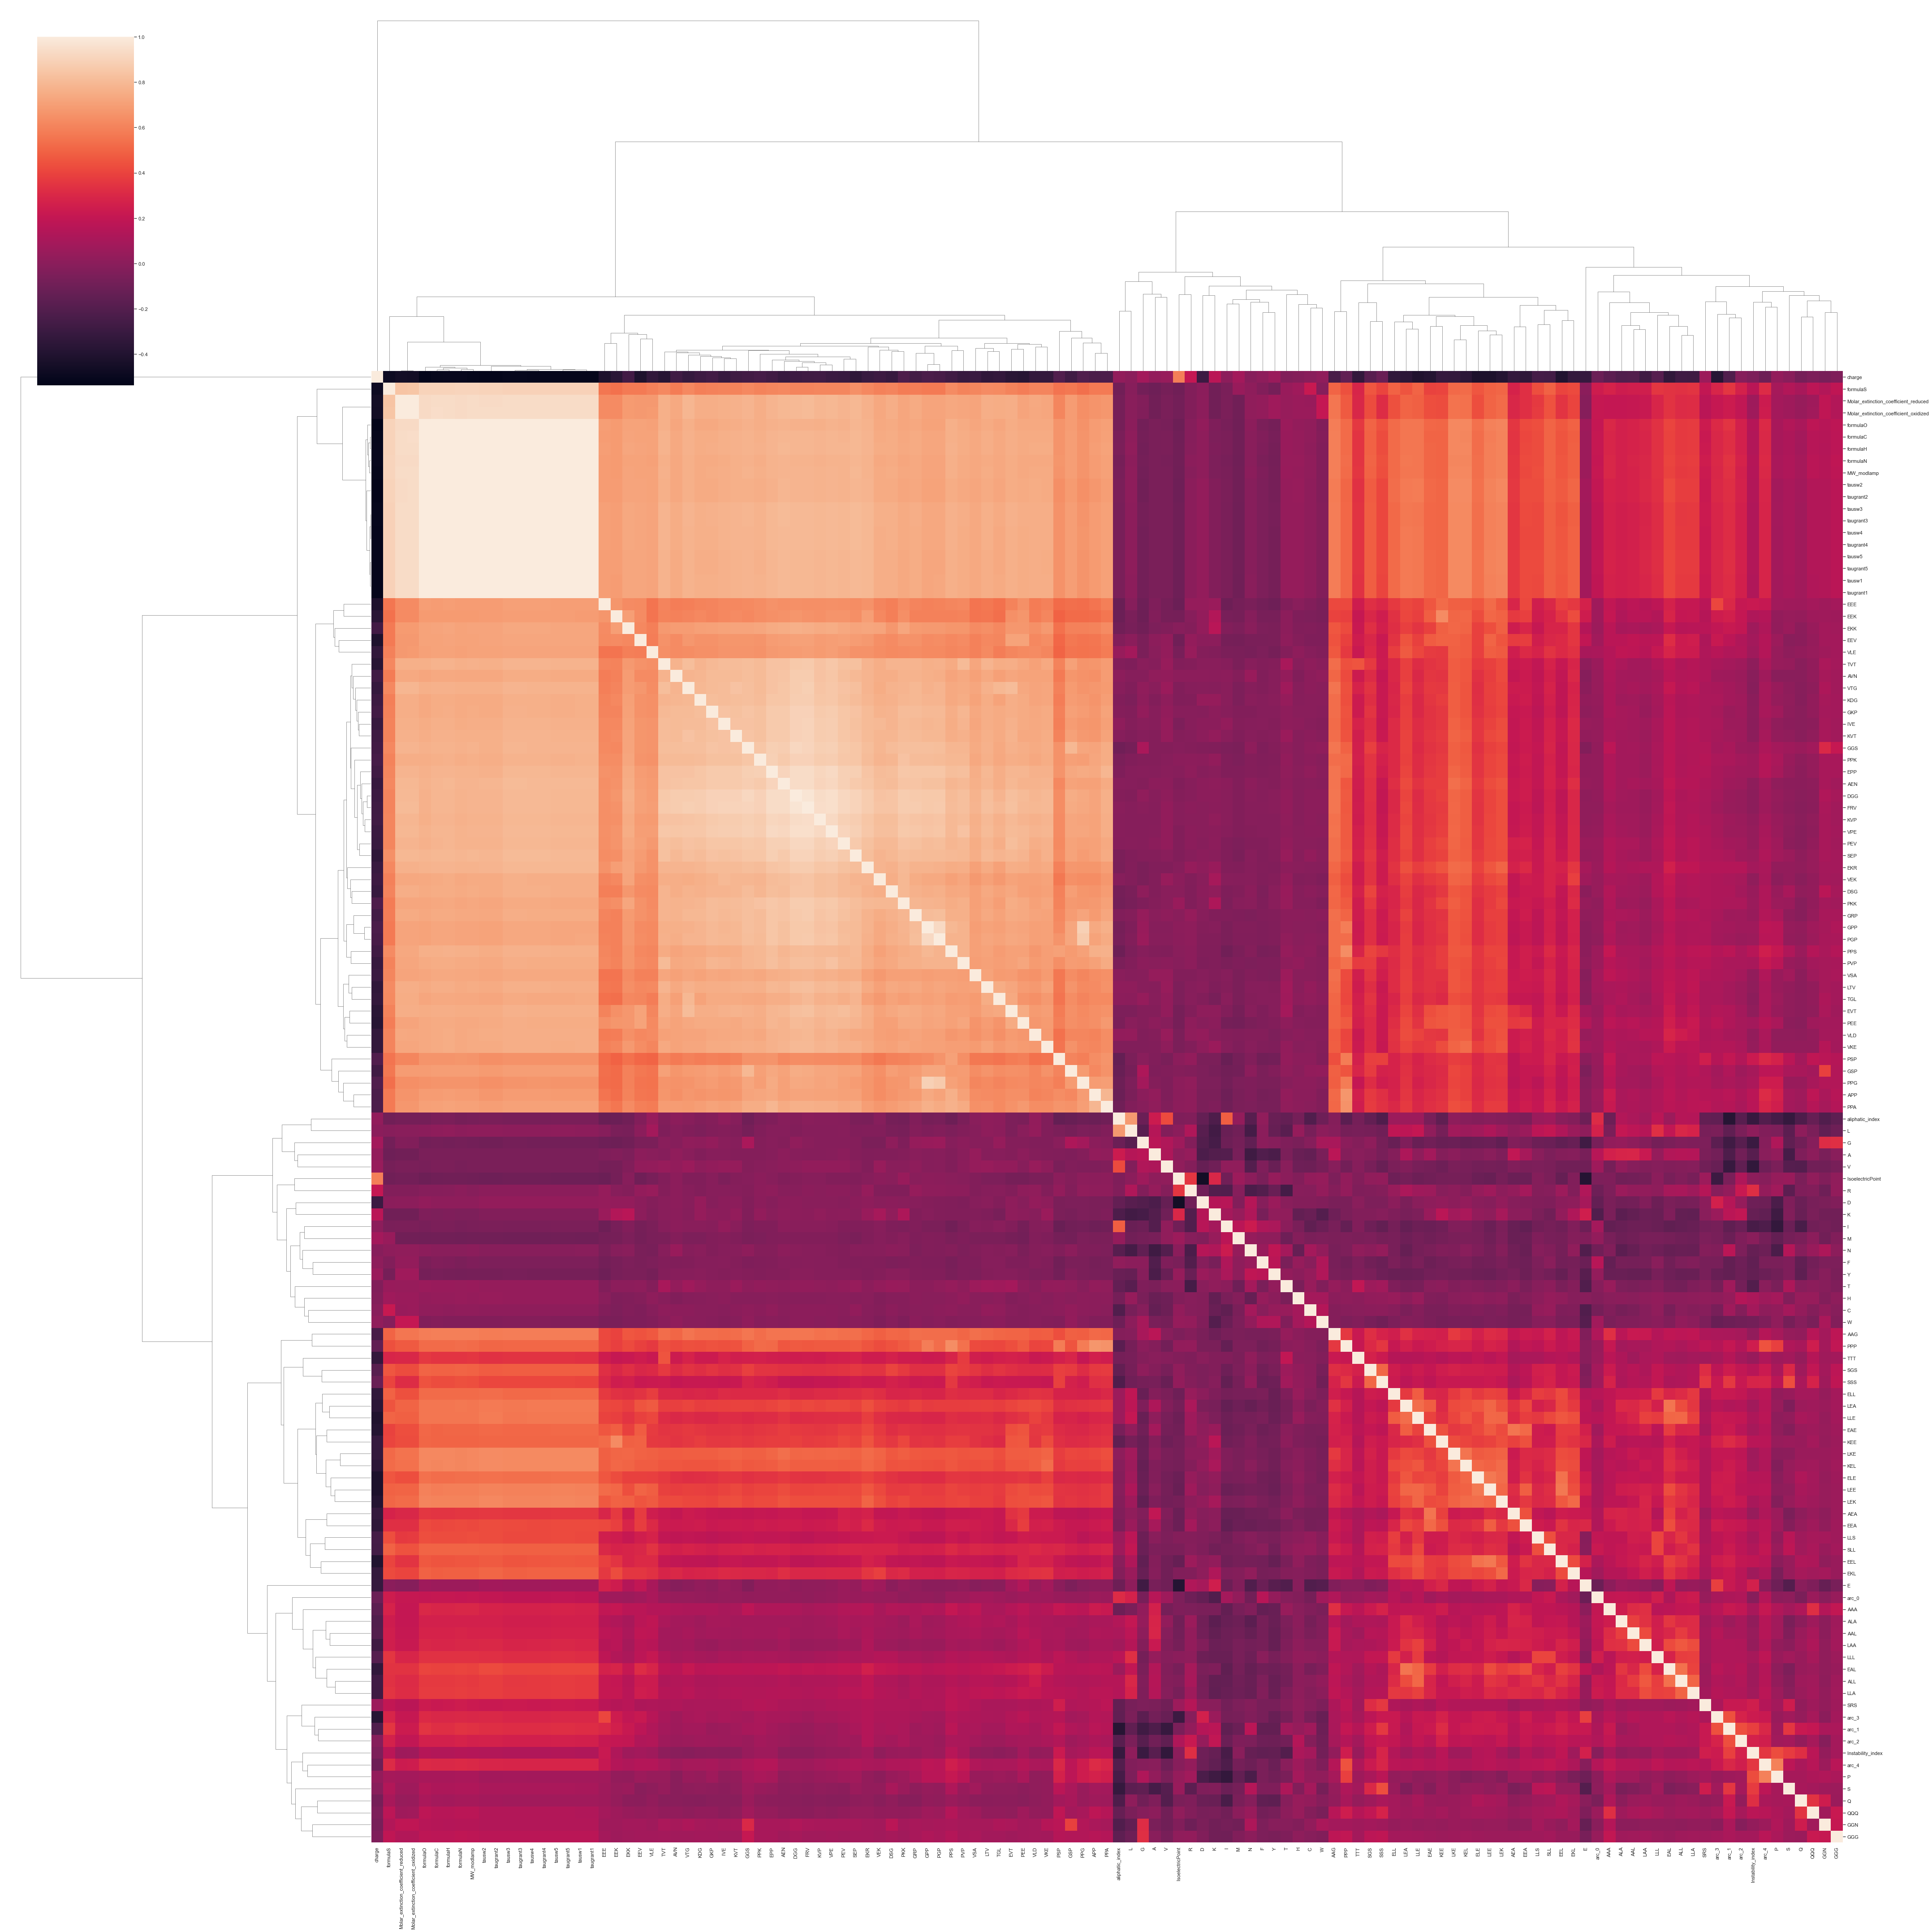

In [68]:
corr_matrix = data_scale.corr()
#sn.heatmap(corr_matrix.iloc[1:,1:], annot=False) # não permite aumentar o figsize
sn.clustermap(corr_matrix.iloc[1:,1:], figsize=(60,60))
corr_matrix

Pela tabela de correlações e respectiva representação como heatmap na figura constatamos que existe um conjunto de features com um alto grau de correlação, ou seja, que acrescentam pouca informação entre si. Observa-se, por exemplo, uma alta correlação entre:
- formulaC, formulaN, formulaO e formulaS, que à excepção da última com 90%, rondam o 99%;
- tamanho, a carga, o Molar_extinction_coefficient_reduced e o Molar_extinction_coefficient_oxidized;
- os diferentes taus, com uma correlação quase absoluta.

Estas correlações são validadas pelo dendograma do clustering hierárquico também mostrado na figura, que as agrupou em primeiro lugar.

Com isto em mente, faça-se então uma seleção das features com correlação muito elevada, que vamos considerar 80%

In [75]:
# Cálculo das features com correlação elevada
max_corr=0.8
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > max_corr:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

print(len(correlated_features), correlated_features)

48 {'IVE', 'taugrant1', 'formulaN', 'tausw2', 'VEK', 'VTG', 'GGS', 'TVT', 'EVT', 'SEP', 'KVP', 'PEE', 'formulaC', 'FRV', 'AEN', 'taugrant5', 'PPG', 'taugrant3', 'KVT', 'VPE', 'LTV', 'Molar_extinction_coefficient_reduced', 'formulaH', 'EKR', 'formulaO', 'tausw4', 'PKK', 'PEV', 'PPS', 'Molar_extinction_coefficient_oxidized', 'AVN', 'PGP', 'GPP', 'KDG', 'taugrant2', 'PVP', 'DGG', 'EPP', 'tausw1', 'GKP', 'GRP', 'MW_modlamp', 'taugrant4', 'formulaS', 'tausw5', 'tausw3', 'DSG', 'PPK'}


Dado o baixo valor informativo destas 48 features causada pela alta correlação, decidimos retira-las da análise seguinte de maneira a obter melhores resultados. Recalculando as correlações sem estas colunas obtemos um subconjunto de features com maior qualidade.

,length,charge,IsoelectricPoint,Instability_index,aliphatic_index,arc_0,arc_1,arc_2,arc_3,arc_4,...,SRS,SGS,SLL,SSS,TGL,TTT,VLD,VLE,VKE,VSA
length,1.000000,-0.518369,-0.097443,0.143693,-0.064556,0.209643,0.331447,0.262532,0.294446,0.305916,...,0.229342,0.499670,0.499706,0.437530,0.737628,0.354938,0.742937,0.711486,0.742882,0.736980
charge,-0.518369,1.000000,0.590594,-0.048162,0.023644,-0.113028,-0.207167,-0.019073,-0.379447,-0.104908,...,0.062690,-0.183567,-0.262708,-0.122159,-0.332061,-0.329175,-0.328447,-0.335497,-0.330454,-0.302517
IsoelectricPoint,-0.097443,0.590594,1.000000,0.003683,-0.043407,-0.045331,-0.056795,0.127884,-0.292194,-0.012470,...,0.062726,0.017255,-0.055659,0.025838,-0.045540,-0.028315,-0.050989,-0.066994,-0.055148,-0.030817
Instability_index,0.143693,-0.048162,0.003683,1.000000,-0.311332,-0.010643,0.387273,0.267914,0.236658,0.355384,...,0.255000,0.157208,0.131841,0.280226,0.003639,0.049631,0.031876,0.069621,0.038306,0.025283
aliphatic_index,-0.064556,0.023644,-0.043407,-0.311332,1.000000,0.311122,-0.378746,-0.185869,-0.148373,-0.201375,...,-0.144361,-0.144148,0.067228,-0.216458,0.003868,-0.077339,0.022101,0.041532,-0.038216,-0.004514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTT,0.354938,-0.329175,-0.028315,0.049631,-0.077339,0.052183,0.147647,0.081867,0.093963,0.126553,...,0.075460,0.269877,0.146380,0.230138,0.260839,1.000000,0.214736,0.221388,0.227685,0.252233
VLD,0.742937,-0.328447,-0.050989,0.031876,0.022101,0.075184,0.104419,0.098189,0.133603,0.112644,...,0.117936,0.313908,0.303665,0.213480,0.649520,0.214736,1.000000,0.630014,0.676223,0.656717
VLE,0.711486,-0.335497,-0.066994,0.069621,0.041532,0.106197,0.130708,0.138636,0.158958,0.142648,...,0.128437,0.305236,0.339932,0.225898,0.581246,0.221388,0.630014,1.000000,0.615376,0.594598
VKE,0.742882,-0.330454,-0.055148,0.038306,-0.038216,0.068436,0.138878,0.116960,0.140842,0.108993,...,0.132090,0.316241,0.287723,0.213098,0.679716,0.227685,0.676223,0.615376,1.000000,0.684328


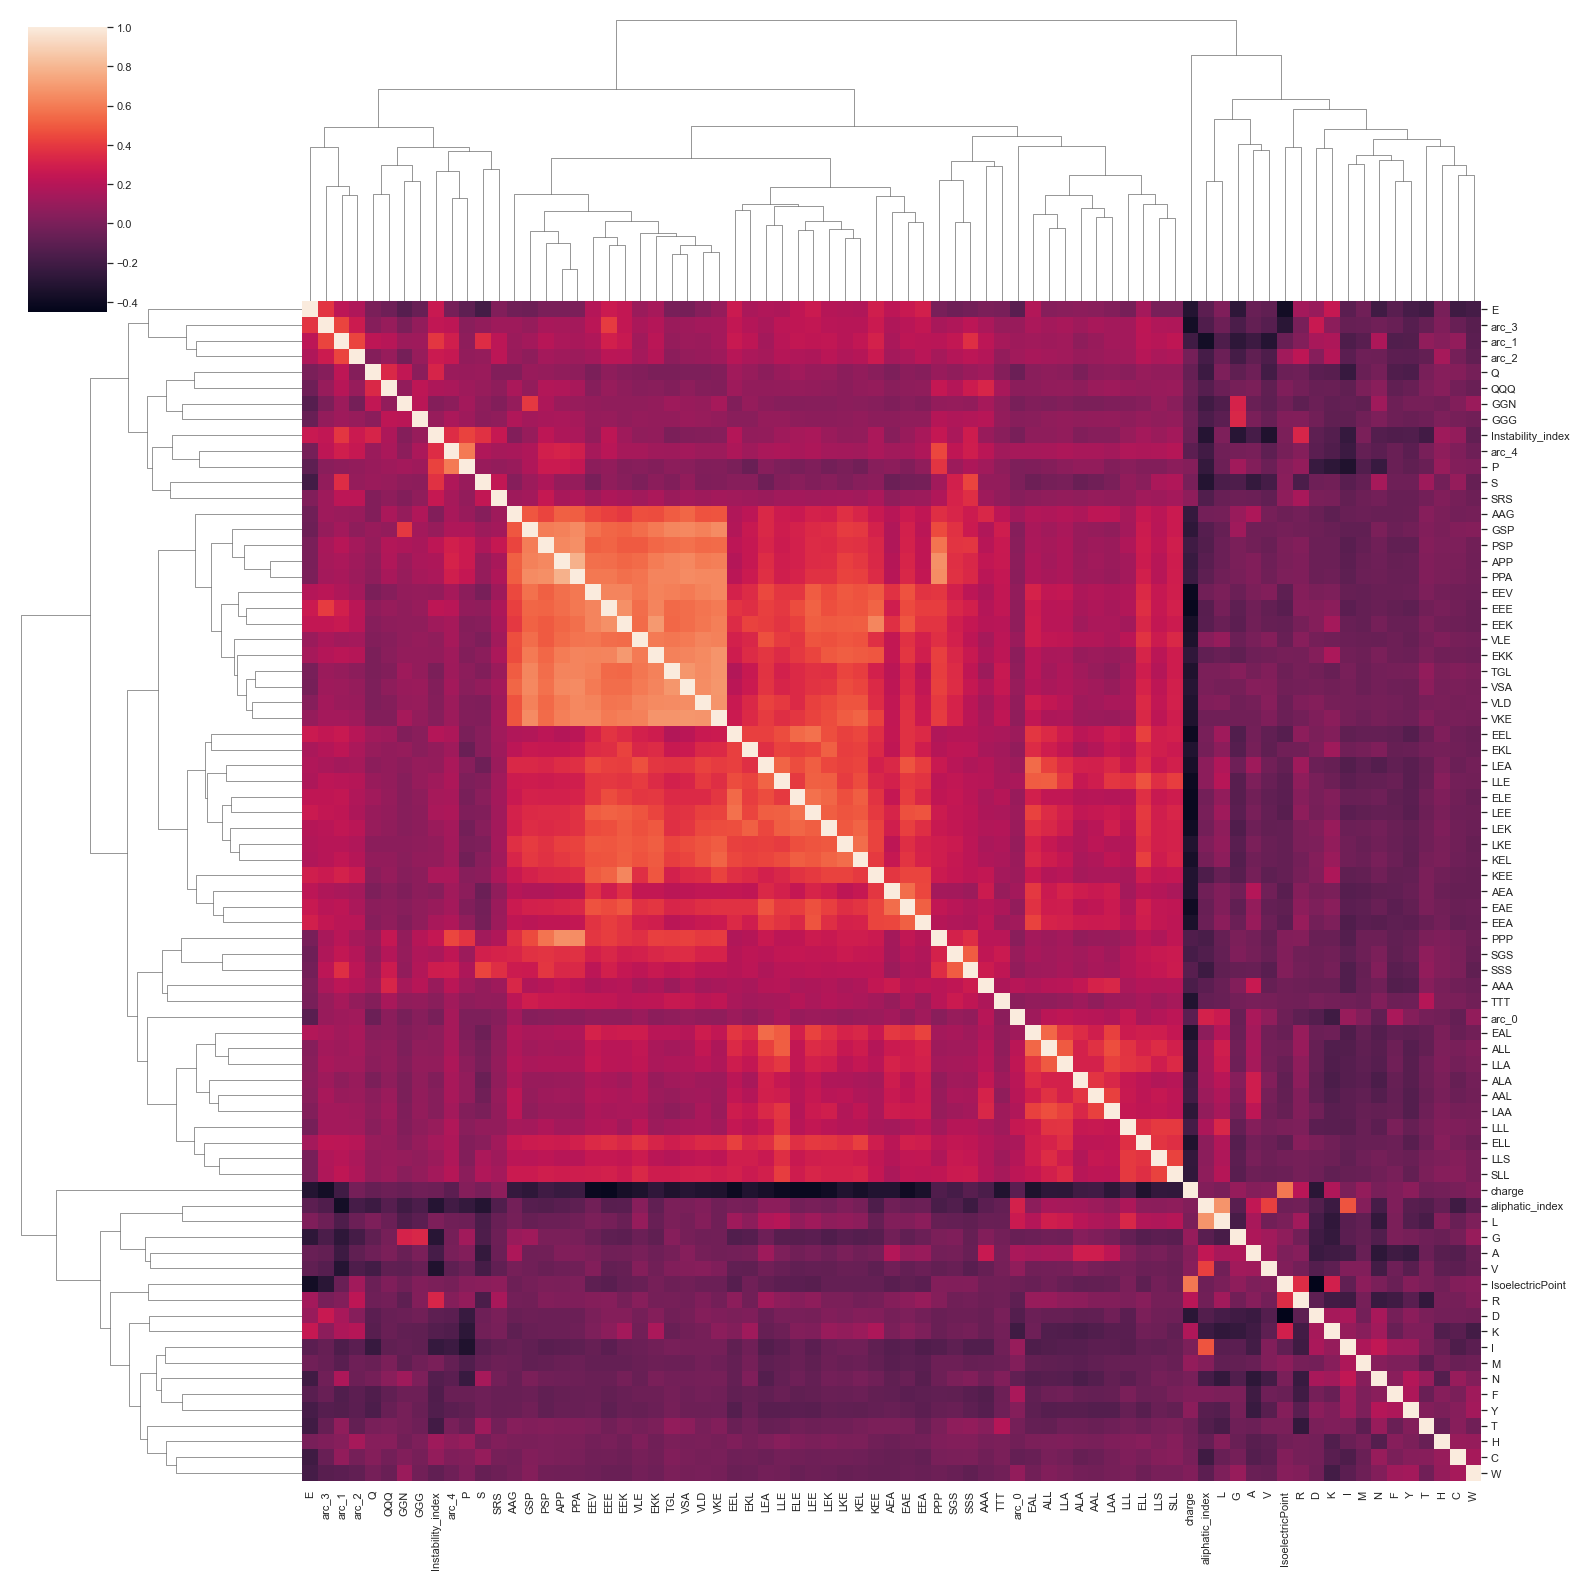

In [81]:
#data_scale.drop(labels = correlated_features, axis = 1, inplace = True)
corr_matrix = data_scale.corr()
sn.clustermap(corr_matrix.iloc[1:,1:], figsize=(22,22))
corr_matrix

------------------------------------------------------------------------------------------------------------------------------------------------------

In [291]:
to_export = pd.concat([data_scale, Y_dataset],axis=1, ignore_index=False)
to_export.to_csv('datasets/all_descriptors_processed.csv')

## Análise não supervisionada

Com os dados resultantes da fase anterior, vamos agora proceder à análise destes dados por via de técnicas não supervisionadas, começando pelo clustering hierárquico.

Observe-se primeiro a atual distribuição de valores de `tm`

                 tm
count  28344.000000
mean      48.955250
std       12.847299
min        9.800000
25%       42.300000
50%       47.900000
75%       53.300000
max       90.500000


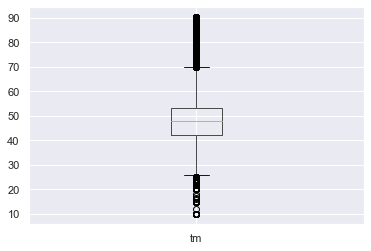

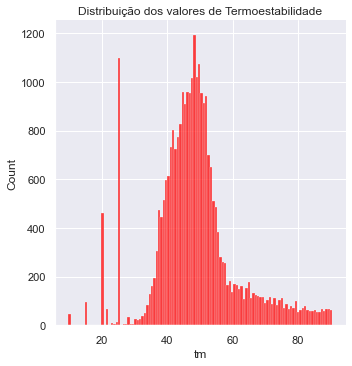

In [275]:
#separar X e Y 
X = data_scale
Y = Y_dataset
summary = Y.describe() #data_Y é pandas dataframe
print(summary)
Y.boxplot()

sn.displot(data = Y, x = 'tm', color = 'red')
plt.xlabel('tm')
plt.title('Distribuição dos valores de Termoestabilidade')
plt.show()

Como mostram as figuras e a tabela, a região de valores dominante inicia por volta de `tm=30` e vai até, aproximadamente, `tm=65`. 

Experimente-se agora fazer uma conversão da variável para uma categórica. Para tal importa primeiro perceber quantas categorias deveríam ser definidas. Assim, vejamos o resultado do clustering hierárquico.

In [276]:
def linkage_matrix(model):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    return linkage_matrix


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)
matrix = linkage_matrix(model)


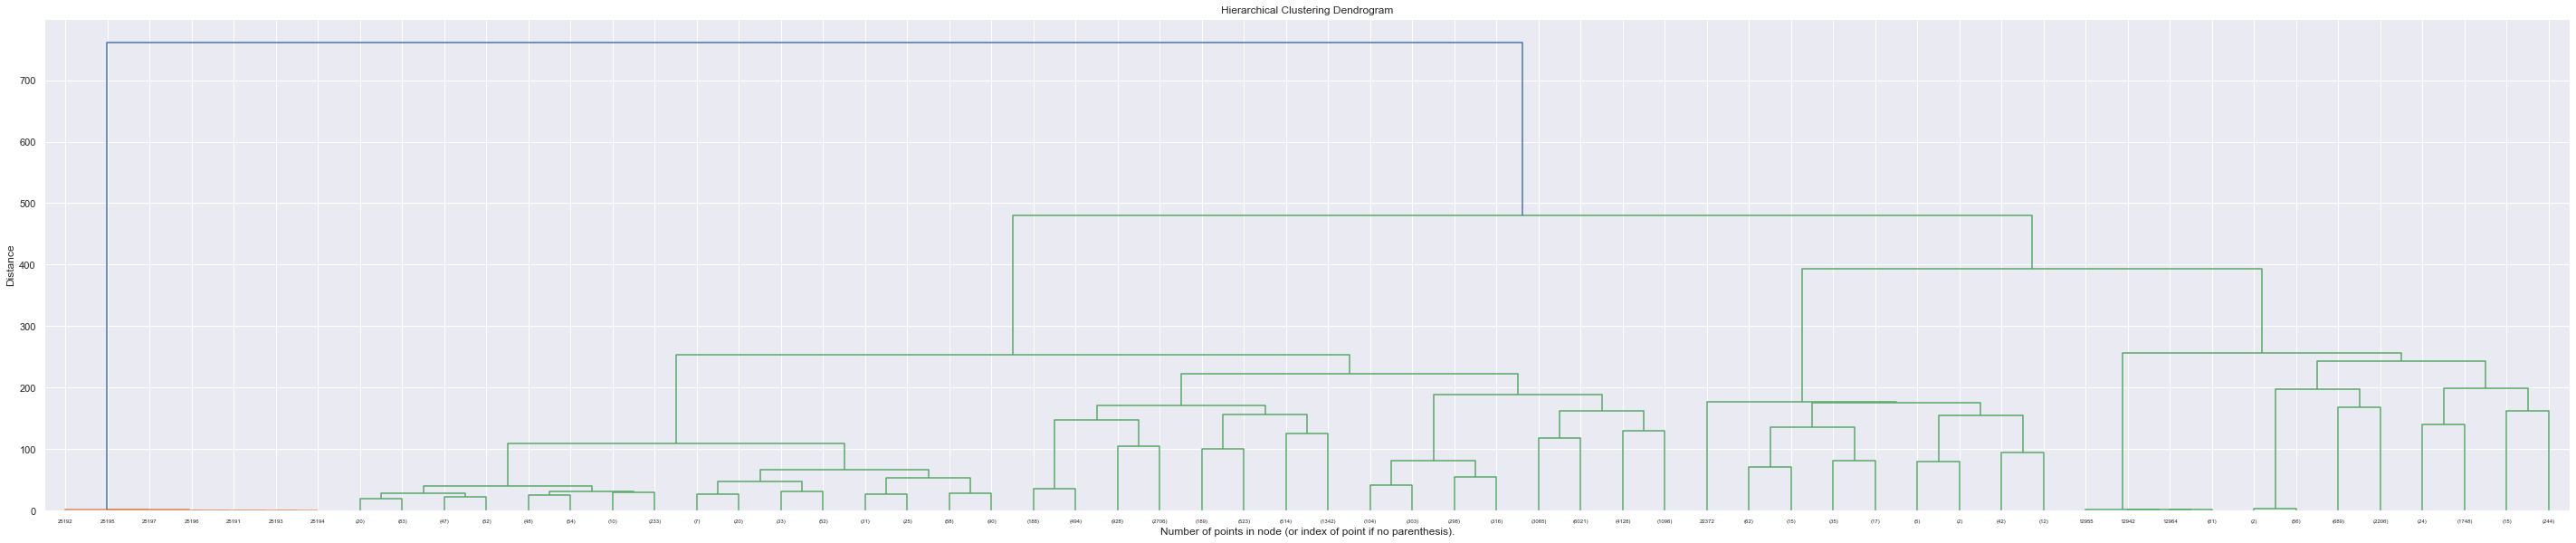

In [277]:
plt.figure(figsize=(50,10))
plt.title("Hierarchical Clustering Dendrogram")
# Plot the corresponding dendrogram
dendrogram(matrix, truncate_mode="level", p=6, leaf_rotation=0)
# plot the top three levels of the dendrogram
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel('Distance')
plt.show()

Pelos resultados mostrados no dendograma, constatamos que um corte para distâncias inferiores a 0.5 (7 clusters) parece ser adequado. 

### Clustering aglomerativo

Procedemos à analise do clustering aglomerativo, tendo em conta as inferências obtidas no dendograma anterior. Considerámos um número de clusters igual a 7.

Vamos explorar a possibilidade de prever o tm em formato categórico e verificar se isto gera clusters com boa separação das categorias.

In [234]:
Y_categorical = Y_dataset.copy() #copia para não alterar Y (nota Y é array)

# criar variavel categorica dividindo os valores de tm de forma uniforme
min = 9.8
max = 90.5
step = (max-min)/7
bins = [min + i*step for i in range(7)]
bins.append(np.inf)
print(bins) 

labels = [
    "muito baixo",
    "baixo",
    "baixo-médio",
    "médio",
    "médio-alto",
    "alto",
    "muito alto"
]
Y_categorical = pd.cut(Y_categorical['tm'], bins, labels=labels).to_frame(name = "tm")


[9.8, 21.32857142857143, 32.85714285714286, 44.385714285714286, 55.91428571428571, 67.44285714285714, 78.97142857142858, inf]


,tm
0,alto
1,médio
2,baixo-médio
3,médio
4,médio
...,...
28696,médio
28697,baixo-médio
28698,médio-alto
28699,médio


In [235]:
hclust = AgglomerativeClustering(n_clusters=7, affinity="euclidean", linkage="ward")
hclust.fit(X)
res_hc = hclust.labels_
pd.crosstab(Y_categorical["tm"], res_hc)
# fazer po scatterplot

col_0,0,1,2,3,4,5,6
tm,,,,,,,
muito baixo,26,1,575,0,0,9,0
baixo,61,42,1005,7,69,174,0
baixo-médio,1589,172,3333,0,42,2283,9
médio,2856,337,6446,0,68,3897,22
médio-alto,374,37,1578,0,3,746,1
alto,144,14,1067,0,0,320,0
muito alto,109,6,669,0,1,251,0


Y categorico

Frequência de cada categoria:



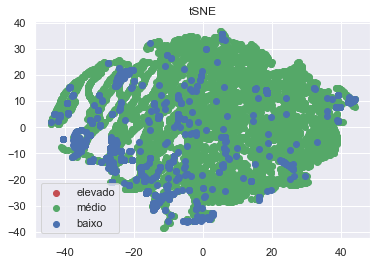

In [237]:
data_Y_categorical = Y_categorical#.to_frame(name = "Y_categorical")

#frequencia de cada categoria
print('Frequência de cada categoria:\n')
data_Y_categorical.groupby("tm").size()


plt.figure()
for c, name in zip("rgb", ["elevado", "médio", "baixo"]):
    plt.scatter(x=(),, c=c, label=name)
plt.title("tSNE")
plt.legend(loc='best', shadow=False)
plt.show()


------------------------------

# Clustering hierárquico

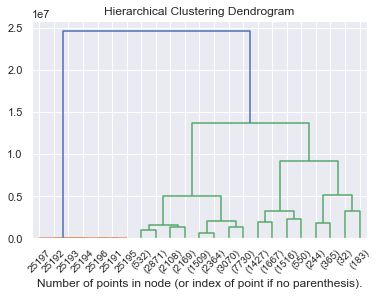

In [210]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

----------------------------------------
# Clustering aglomerativo

In [211]:
hclust = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
hclust.fit(X)
res_hc = hclust.labels_
pd.crosstab(data_Y_categorical["tm"], res_hc)

col_0,0,1,2
tm,,,
muito baixo,27,0,584
baixo,172,7,1179
baixo-médio,1812,0,5616
médio,3283,0,10343
médio-alto,415,0,2324
alto,158,0,1387
muito alto,116,0,920


In [215]:
from sklearn.cluster import KMeans
k=3

kmeans_dataset = KMeans(n_clusters=k, max_iter=1000)
kmeans_dataset.fit(X)
kmeans_dataset.predict(X)

labels = kmeans_dataset.labels_
print(labels)

centroids = kmeans_dataset.cluster_centers_
print(centroids)

pd.crosstab(labels,data_Y_categorical["tm"], rownames=['clusters'] )

[1 1 1 ... 1 1 0]
[[ 1.238e+03 -1.949e+01  6.063e+03  9.458e+03  1.637e+03  1.935e+03
   4.757e+01  1.386e+05  6.365e+00  4.470e+01  1.427e+05  1.440e+05
   8.094e+01  4.399e+02  4.493e+02  4.352e+02  4.351e+02  4.458e+02
   4.399e+02  4.493e+02  4.352e+02  4.351e+02  4.458e+02  1.797e+02
   2.522e+02  8.154e+01  8.415e+01  5.197e+01  6.959e+00  5.248e+00
   4.347e+00  5.549e+00  1.642e+00  7.061e+00  4.690e+00  6.596e+00
   2.419e+00  5.022e+00  9.401e+00  5.820e+00  2.193e+00  3.869e+00
   5.343e+00  7.659e+00  5.364e+00  1.534e+00  3.169e+00  6.115e+00
   9.627e-01  5.555e-01  7.493e-01  5.727e-01  2.604e-01  7.150e-01
   9.828e-01  4.063e-01  2.202e-01  2.826e-01  4.004e-01  6.096e-01
   9.544e-01  6.913e-01  9.124e-01  9.340e-01  5.954e-01  5.330e-01
   7.624e-01  9.029e-01  3.782e-01  7.991e-01  4.667e-01  2.297e-01
   3.625e-01  6.247e-01  2.344e-01  5.351e-01  5.561e-01  6.517e-01
   2.536e-01  3.072e-01  5.173e-01  2.590e-01  8.352e-01  7.422e-01
   8.946e-01  7.946e-01  9.254

tm,muito baixo,baixo,baixo-médio,médio,médio-alto,alto,muito alto
clusters,,,,,,,
0,27,119,1004,1907,208,66,47
1,584,1232,6424,11719,2531,1479,989
2,0,7,0,0,0,0,0


In [216]:
from sklearn.cluster import KMeans
k=4

kmeans_dataset = KMeans(n_clusters=k, max_iter=1000)
kmeans_dataset.fit(X)
kmeans_dataset.predict(X)

labels = kmeans_dataset.labels_
print(labels)

centroids = kmeans_dataset.cluster_centers_
print(centroids)

pd.crosstab(labels,data_Y_categorical["tm"], rownames=['clusters'] )


[2 2 2 ... 2 2 0]
[[ 8.176e+02 -1.050e+01  4.017e+03  6.266e+03  1.082e+03  1.270e+03
   3.082e+01  9.152e+04  6.479e+00  4.356e+01  9.420e+04  9.495e+04
   8.170e+01  2.904e+02  2.973e+02  2.875e+02  2.870e+02  2.938e+02
   2.904e+02  2.973e+02  2.875e+02  2.870e+02  2.938e+02  1.718e+02
   2.350e+02  7.599e+01  7.718e+01  4.775e+01  7.167e+00  5.223e+00
   4.331e+00  5.560e+00  1.535e+00  7.065e+00  4.422e+00  6.640e+00
   2.370e+00  5.116e+00  9.387e+00  5.997e+00  2.253e+00  3.978e+00
   5.254e+00  7.431e+00  5.315e+00  1.483e+00  3.275e+00  6.199e+00
   6.811e-01  4.168e-01  5.535e-01  4.343e-01  1.706e-01  5.103e-01
   5.926e-01  2.726e-01  1.488e-01  1.922e-01  2.308e-01  4.194e-01
   5.385e-01  5.066e-01  6.543e-01  5.902e-01  4.442e-01  3.757e-01
   4.737e-01  5.923e-01  2.411e-01  5.111e-01  3.309e-01  1.640e-01
   2.269e-01  3.908e-01  1.502e-01  3.120e-01  3.989e-01  4.249e-01
   1.689e-01  2.222e-01  3.002e-01  1.803e-01  5.283e-01  4.477e-01
   5.955e-01  5.072e-01  6.086

tm,muito baixo,baixo,baixo-médio,médio,médio-alto,alto,muito alto
clusters,,,,,,,
0,27,113,1992,3580,452,189,142
1,0,7,0,0,0,0,0
2,584,1128,5317,9807,2272,1353,891
3,0,110,119,239,15,3,3


------------------------------
# PCA

Var. explicada: [9.726e-01 2.738e-02 6.944e-06 1.069e-06 1.816e-07 1.590e-07 7.979e-08]
Soma: 99.99997638969447 %



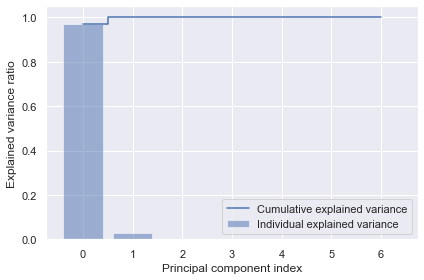

In [217]:
import matplotlib.pyplot as plt
%matplotlib inline
pca = PCA(n_components=7) #experimentar diferentes valores de n_components
pca.fit(X)

X_r = pca.transform(X) # transformacao dos dados no novo espaço utilizando apenas n CP

print('Var. explicada: %s'% str(pca.explained_variance_ratio_))
print('Soma:', sum(pca.explained_variance_ratio_) * 100, "%")

print()

exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

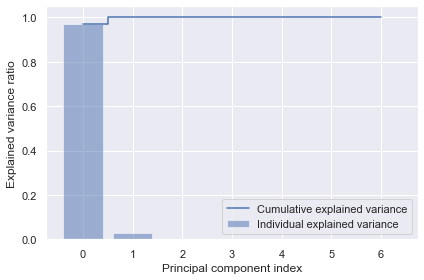

In [ ]:
meta_values = data_Y_categorical["tm"]
plt.figure()
for c, name in zip("rgb", ['muito baixo','baixo','baixo-médio','médio','médio-alto','alto','muito alto']):
    plt.scatter(X_r[meta_values == name, 0], X_r[meta_values == name, 1], c=c, label=name)
plt.legend()
plt.title('PCA - tm')
plt.show()


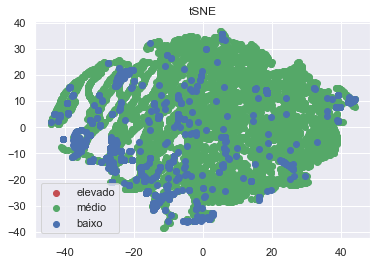

In [223]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, n_iter=1000)
points = tsne.fit_transform(X)
meta_values = data_Y_categorical["tm"]

plt.figure()
for c, name in zip("rgb", ["elevado", "médio", "baixo"]):
    plt.scatter(points[meta_values == name, 0], points[meta_values == name, 1], c=c, label=name)
plt.title("tSNE")
plt.legend(loc='best', shadow=False)
plt.show()


In [195]:
Y_categorical = Y_dataset.copy() #copia para não alterar Y (nota Y é array)

data_Y_categorical = Y_categorical

hclust = AgglomerativeClustering(n_clusters=2, affinity="euclidean", linkage="ward")
hclust.fit(X)
res_hc = hclust.labels_
pd.crosstab(data_Y_categorical["Y_categorical"], res_hc)


KeyError: 'Y_categorical'

In [ ]:

# criar variavel categorica dividindo os valores de tm de forma uniforme
min = 9.8
max = 90.5
step = (max-min)/7
bins = [min + i*step for i in range(7)]
bins.append(np.inf)
print(bins) 

labels = [
    "muito baixo",
    "baixo",
    "baixo-médio",
    "médio",
    "médio-alto",
    "alto",
    "muito alto"
]
Y_categorical = pd.cut(Y_categorical['tm'], bins, labels=labels).to_frame(name = "tm")


TypeError: 'value' must be an instance of str or bytes, not a float

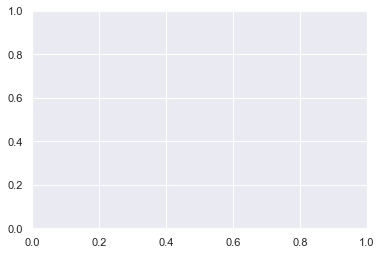

In [192]:
meta_values = Y_categorical["tm"]
plt.figure()
for c, name in zip("rgb", labels):
    plt.scatter(res_hc, Y_categorical["tm"], c=c, label=name)
plt.legend()
plt.title('AgglomerativeClustering - tm')
plt.show()


plt.bar(range(4), pca_SM.explained_variance_ratio_[:4]*100)
plt.xticks(range(4), ['PC'+str(i) for i in range(1,5)])
plt.title("Variância explicada por PC")
plt.ylabel("Percentagem")
plt.show()

Clustering kmeans

In [133]:
from sklearn.cluster import KMeans
k=6

kmeans_dataset = KMeans(n_clusters=k, max_iter=1000)
kmeans_dataset.fit(X)
kmeans_dataset.predict(X)

labels = kmeans_dataset.labels_
print(labels)

centroids = kmeans_dataset.cluster_centers_
print(centroids)

pd.crosstab(labels,Y["tm"], rownames=['clusters'] )

[0 0 2 ... 0 2 4]
[[ 2.512e+02 -1.615e+00  1.225e+03  1.939e+03  3.315e+02  3.840e+02
   9.612e+00  2.789e+04  6.948e+00  3.897e+01  2.173e+04  2.191e+04
   8.659e+01  9.087e+01  9.274e+01  8.874e+01  8.850e+01  9.028e+01
   9.087e+01  9.274e+01  8.874e+01  8.850e+01  9.028e+01  1.364e+02
   1.812e+02  6.011e+01  5.877e+01  3.274e+01  8.059e+00  5.466e+00
   4.176e+00  5.552e+00  1.412e+00  7.179e+00  3.952e+00  6.995e+00
   2.090e+00  5.691e+00  9.290e+00  6.880e+00  2.557e+00  3.691e+00
   4.425e+00  6.482e+00  5.249e+00  9.462e-01  2.975e+00  6.933e+00
   2.310e-01  1.697e-01  2.284e-01  1.366e-01  6.510e-02  2.116e-01
   2.062e-01  6.579e-02  7.659e-02  5.078e-02  9.140e-02  1.407e-01
   2.350e-01  1.588e-01  1.559e-01  1.745e-01  1.247e-01  1.218e-01
   1.244e-01  1.748e-01  6.805e-02  2.189e-01  1.072e-01  3.867e-02
   6.259e-02  5.524e-02  5.317e-02  5.141e-02  1.525e-01  1.012e-01
   6.610e-02  4.011e-02  5.053e-02  7.401e-02  1.964e-01  1.633e-01
   1.759e-01  1.520e-01  1.885

tm,9.8,9.9,10.0,12.0,15.0,16.0,16.6,17.2,18.0,20.0,...,89.6,89.7,89.8,89.9,90.0,90.1,90.2,90.3,90.4,90.5
clusters,,,,,,,,,,,,,,,,,,,,,
0,0,0,22,1,96,0,1,1,1,461,...,11,7,3,5,4,7,7,5,7,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,1,7,2,4,3,3,3,1,2,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,24,0,0,1,1,0,0,0,1,...,1,0,0,1,0,1,1,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
from sklearn.cluster import KMeans
k=12

kmeans_dataset = KMeans(n_clusters=k, max_iter=1000)
kmeans_dataset.fit(X)
kmeans_dataset.predict(X)

labels = kmeans_dataset.labels_
print(labels)

centroids = kmeans_dataset.cluster_centers_
print(centroids)

pd.crosstab(labels,Y["tm"], rownames=['clusters'] )


[2 2 5 ... 2 5 4]
[[ 4.618e+02 -4.546e+00  2.301e+03 ...  1.153e-01  1.614e-01  1.332e-01]
 [ 3.277e+04 -3.296e+02  1.611e+05 ...  8.200e+01  3.700e+01  5.100e+01]
 [ 2.689e+02 -1.713e+00  1.315e+03 ...  7.597e-02  1.030e-01  7.520e-02]
 ...
 [ 6.455e+02 -7.925e+00  3.213e+03 ...  1.563e-01  1.730e-01  1.624e-01]
 [ 1.267e+03 -1.504e+01  6.130e+03 ...  3.627e-01  4.684e-01  3.007e-01]
 [ 1.661e+02 -1.601e-01  8.054e+02 ...  3.672e-02  7.742e-02  7.568e-02]]


tm,9.8,9.9,10.0,12.0,15.0,16.0,16.6,17.2,18.0,20.0,...,89.6,89.7,89.8,89.9,90.0,90.1,90.2,90.3,90.4,90.5
clusters,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,3,0,1,1,2,2,0,2,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,93,0,1,0,0,428,...,6,2,1,1,0,4,4,2,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
5,0,0,5,0,0,0,0,0,0,4,...,2,5,2,4,3,1,1,3,2,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


------------------------------------------------------------------------------------------------------------------------------------------------------

PCA

Var. explicada: [9.726e-01 2.738e-02 6.944e-06 1.069e-06 1.816e-07]
Soma: 99.99995251575073 %


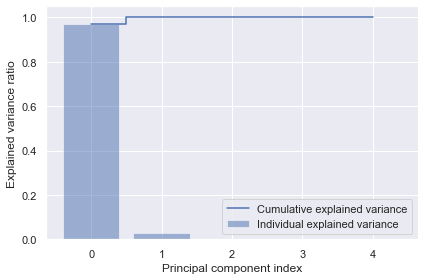

In [158]:
pca = PCA(n_components=5) #experimentar diferentes valores de n_components
pca.fit(X)

X_r = pca.transform(X) # transformacao dos dados no novo espaço utilizando apenas n CP

print('Var. explicada: %s'% str(pca.explained_variance_ratio_))
print('Soma:', sum(pca.explained_variance_ratio_) * 100, "%")

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

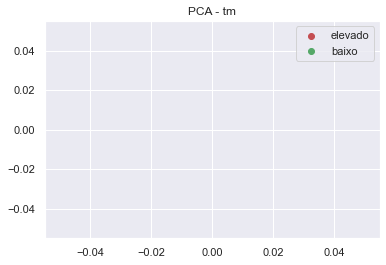

In [159]:
meta_values = Y["tm"]
plt.figure()
for c, name in zip("rgb", ["elevado", "baixo"]):
    plt.scatter(X_r[meta_values == name, 0], X_r[meta_values == name, 1], c=c, label=name)
plt.legend()
plt.title('PCA - tm')
plt.show()


Considerando dois componentes principais, apenas é explicada cerca de 50% da variabilidade do dataset. Neste caso, observa-se ainda marcada sobreposição / similaridade das duas categorias (tm alto / baixo) da variável dependente.

Uma vez que pretendiamos um número de componentes principais que explicasse pelo menos 95% da variabilidade do dataset, fizemos um gráfico que nos permitisse inferir esse valor.


In [ ]:
pca = PCA().fit(X)

plt.rcParams["figure.figsize"] = (8,5)

fig, ax = plt.subplots()
xi = np.arange(1, 23, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='black')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 14, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='grey', linestyle='--')
plt.text(1.1, 1, '95% cut-off threshold', color = 'black', fontsize=16)

ax.grid(axis='x')
plt.tight_layout()
plt.savefig('pcavisualize_1.png', dpi=300)
plt.show()

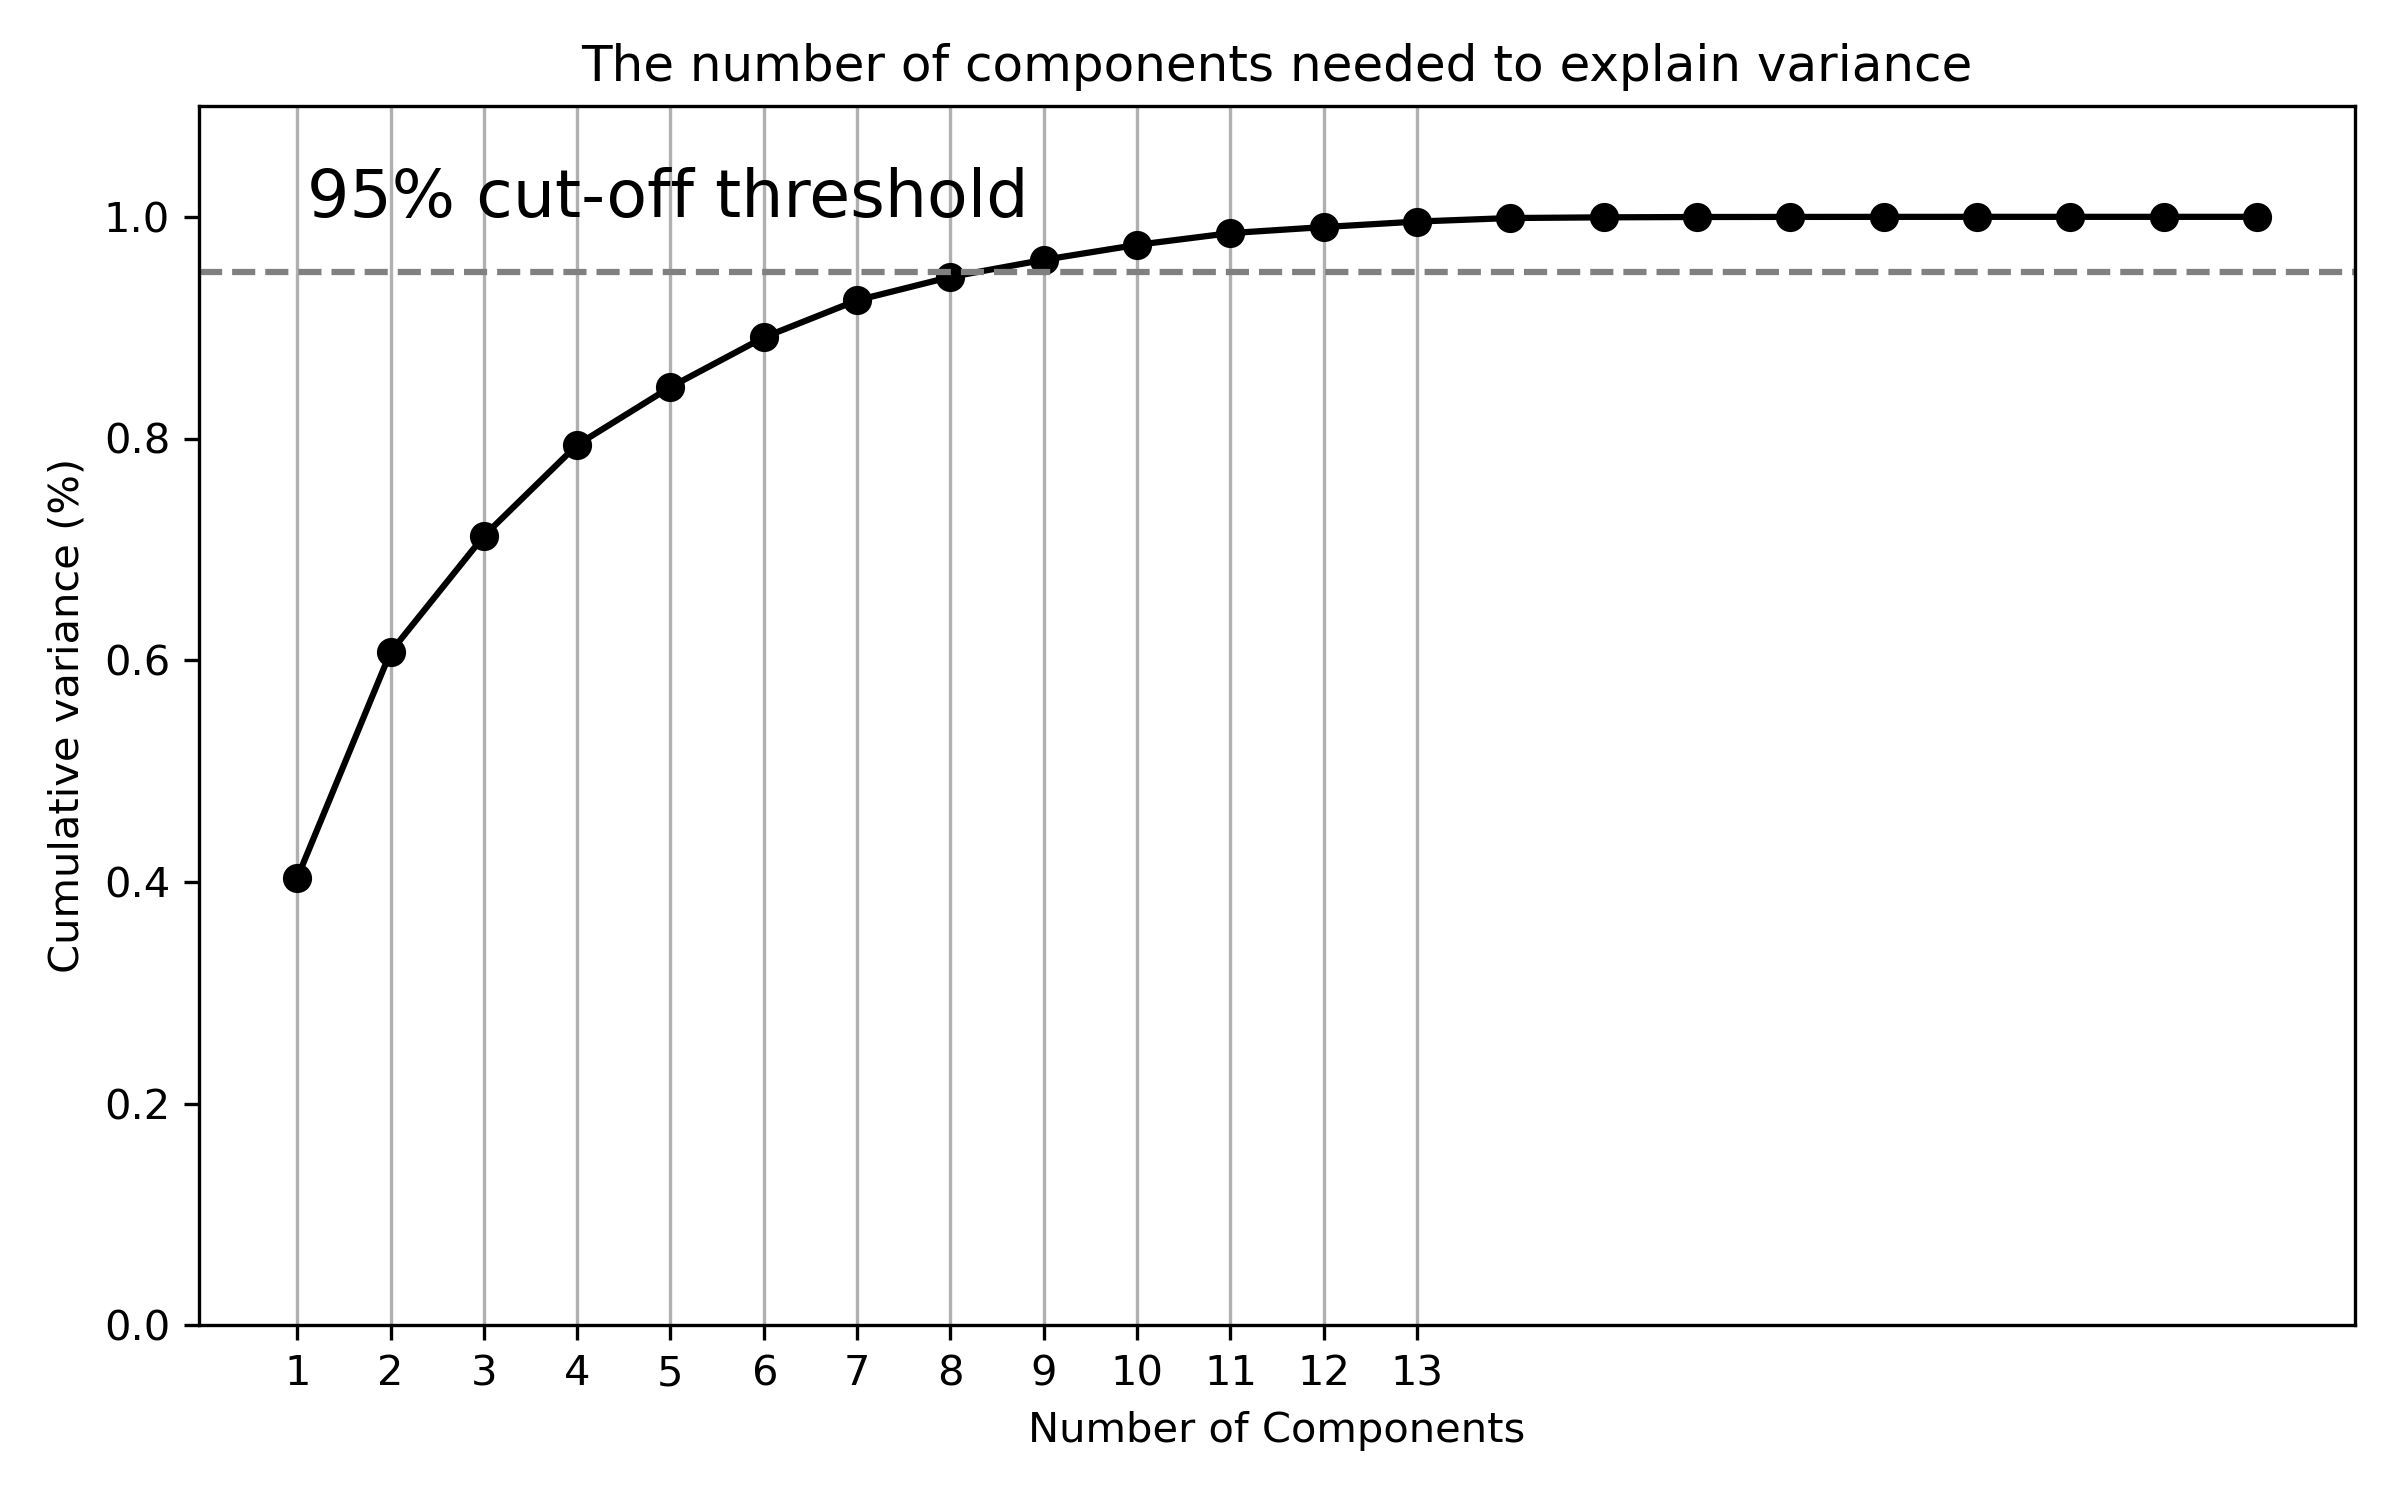


Assim, concluimos ser possível prever uma variabilidade do dataset superior a 95% ao somar as variâncias cumulativas esperadas de oito componentes principais.

Tal como esperado, o aumento do número de componentes principais conduz a uma maior soma cumulativa das variâncias esperadas. Se pretendessemos reduzir a dimensionalidade do dataset, poderiamos usar apenas esses componentes nas análises seguintes e, num processo iterativo, verificar se seriam obtidos resultados melhores.


In [29]:
pca = PCA(n_components=8)
pca.fit(X)

X_r = pca.transform(X) #

print('Var. explicada: %s'% str(pca.explained_variance_ratio_))
print('Soma:', sum(pca.explained_variance_ratio_) * 100, "%")

Var. explicada: [0.29  0.184 0.139 0.094 0.09  0.073 0.062 0.033]
Soma: 96.52637164900989 %


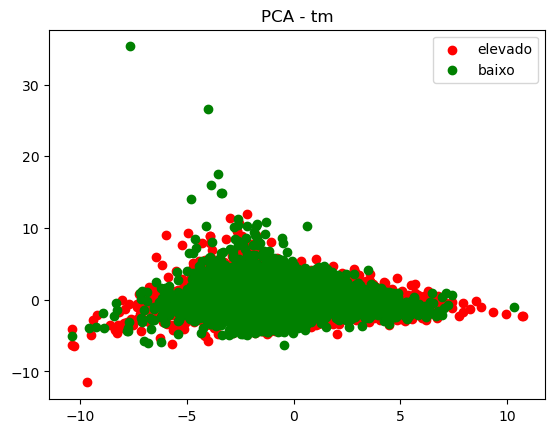

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

TSNE

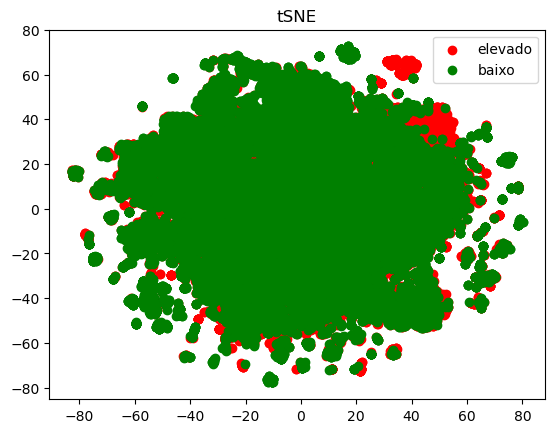

In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=1000)
points = tsne.fit_transform(X)
meta_values = Y["Y_categorical"]

plt.figure()
for c, name in zip("rgb", ["elevado", "baixo"]):
    plt.scatter(points[meta_values == name, 0], points[meta_values == name, 1], c=c, label=name)
plt.title("tSNE")
plt.legend(loc='best', shadow=False)
plt.show()


------------------------------------------------------------------------------------------------------------------------------------------------------

# Etapa 3 - Aprendisagem máquina

Vamos agora proceder ao treino de modelos de diferentes naturezas e estudar a sua capacidade de prever a termoestabilidade.

A partir deste momento, o nosso y é uma variavel binaria em que 0 representa um tm baixo em relação à média e 1 reprensenta um tm elevado em relação à média.

In [262]:
data_y = Y_categorical.replace(["muito baixo","baixo","baixo-médio","médio","médio-alto","alto","muito alto"], [0,1,2,3,4,5,6])
data_y.groupby("tm").size()

tm
0      611
1     1358
2     7428
3    13626
4     2739
5     1545
6     1036
dtype: int64

Existem 16 341 valores de tm inferiores à média e 12 398 valores de tm superiores à média

In [263]:
data_y.groupby("tm").size()

tm
0      611
1     1358
2     7428
3    13626
4     2739
5     1545
6     1036
dtype: int64

Dividir os dados em treino e em teste

In [264]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y_categorical, test_size = 0.25, random_state = 500)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (21258, 124) (21258, 1)
Test:  (7086, 124) (7086, 1)


Regressão e curva roc

In [251]:
# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression()
# model.fit(X_train,y_train)

In [265]:
def score_test_set(model, X_test, y_test):
    # score test set
    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)
    except:
        y_prob = None
    print('accuracy', accuracy_score(y_test, y_pred))
    print('MCC', matthews_corrcoef(y_test, y_pred))
    print('f1 score', f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('fdr', float(fp) / (tp + fp))
    print('sn', float(tp) / (tp + fn))
    print('sp', float(tn) / (tn + fp))

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [260]:
score_test_set(model, X_test, y_test)
# ROC_AUC
# prediction = model.predict_proba(X_test)

preds = model.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'g', label='AUC = %0.3f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('ROC AUC score:', round(roc_auc, 4))

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

##### --> Regressão Logística e curva ROC:

Obtivemos um f1-score de 0.72 para termoestabilidade baixa, e 0.40 para elevada. 

A área sob a curva AUC resume a performance do modelo;
A forma da curva mostra a taxa de falsos positivos esperada e a taxa de falsos negativos; É apropriada quando as observações são balanceadas entre as classes.

Quanto menores os valores no eixo x indica menos falsos positivos e mais verdadeiros negativos.
Quanto maiores os valores no eixo y indica mais verdadeiros positivos e menos falsos negativos.

Neste caso, os valores estão mais próximos do eixo y, mostrando assim que temos mais valores Verdadeiros Positivos do que Falsos Negativos.

------------------------------------------------------------------------------------------------------------------------------------------------------

Comparar os modelos com e sem pesos

Como as proporções entre as 2 categorias de y são diferentes, os pesos vão ser diferentes também.
Assim, para a categoria '0' que tem 16 341, a proporção vai ser de 0.75, enquanto que para a categoria '1' que tem 12 398, a porpoção vai ser 1.

In [267]:
#Test and compare multiple models
class_weight={0:1/7,  1:2/7, 2:3/7, 3:4/7, 4:5/7, 5:6/7, 6:1}
#class_weight={0: 0.75, 1: 1}
models = [('LR', LogisticRegression()),
          ('LR-W', LogisticRegression(class_weight=class_weight)),
          ('RF', RandomForestClassifier()),
          ('RF-W', RandomForestClassifier(class_weight=class_weight)),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()),
          ('SVM-W', SVC(class_weight=class_weight)),
          ('DT', DecisionTreeClassifier()),
          ('DT-W', DecisionTreeClassifier(class_weight=class_weight))]


names = []
results = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cross_val = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    results.append(cross_val)
    names.append(name)
    msg = "%s: %f SD:%f" % (name, cross_val.mean(), cross_val.std())
    print(msg)


LR: nan SD:nan


ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py", line 1196, in fit
    X, y = self._validate_data(
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py", line 554, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py", line 1120, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py", line 1142, in _check_y
    _assert_all_finite(y, input_name="y", estimator_name=estimator_name)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py", line 111, in _assert_all_finite
    raise ValueError("Input contains NaN")
ValueError: Input contains NaN

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\_parallel_backends.py", line 597, in __init__
    self.results = batch()
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py", line 320, in _logistic_regression_path
    class_weight_ = compute_class_weight(class_weight, classes=classes, y=y)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\class_weight.py", line 72, in compute_class_weight
    raise ValueError(
ValueError: The classes, ['alto', 'baixo', 'baixo-médio', 'muito alto', 'muito baixo', 'médio', 'médio-alto'], are not in class_weight


plot dos resultados -- all models

NameError: name 'results' is not defined

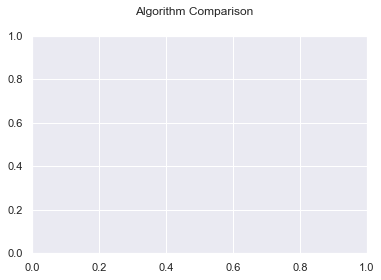

In [239]:
# Plot the results
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Os valores de cross val vão de 0.0 a 1.0, onde quanto mais próximo de 1.0, melhor.
Neste caso podemos observar que os melhores modelos paratreinar os dados são: 

    - Regressão logistica com pesos
    - Random Forest com e sem pesos
    - KNN
    - SVM com pesos
    - Decision trees com e sem pesos
    


In [ ]:
columns = X.columns
columns

SVM

In [ ]:
param_grid = {'C': [0.01,0.1,1],
#               'C': [0.1, 1, 10]
              'kernel': ['linear']}

#hyperparameter optimization algorithm
grid = GridSearchCV(SVC(), param_grid, cv=5, refit = True, verbose = 3)
# fitting the model for grid search
grid.fit(X_train, y_train)
print(grid.best_params_)


#SCORE THE TEST SET
score_test_set(grid, X_test, y_test)


#feature importance
pd.Series(abs(grid.best_estimator_.coef_[0]), index=columns).nlargest(20).plot(kind='barh')


No SVM podemos ver que os melhores parâmetros foram : {'C': 1, 'kernel': 'linear'}. Apresenta uma accuracy de 0.61 e um f1 score de 0.22. 
Pela matriz de confusao podemos ver que existe um elevado número de Falsos Positivos (2651).

Regressão logistica sem peso com RandomizedSearchCV

In [ ]:
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,random_state=0)

distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])

clf = RandomizedSearchCV(logistic, distributions, random_state=0)
clf
search = clf.fit(X_train, y_train)
search.best_params_

score_test_set(search, X_test, y_test)

pd.Series(abs(search.best_estimator_.coef_[0]), index=columns).nlargest(20).plot(kind='barh')

No LR com RandomizedSearch podemos ver que:

Apresenta uma accuracy de:  0.61

Apresenta um f1 score de: 0.39

Pela matriz de confusao podemos ver que existe um elevado número de Falsos Positivos (2143).

RandomForest sem pesos com RandomizedSearchCV¶

In [ ]:
param_grid = {'n_estimators': [10, 100, 200]}

#hyperparameter optimization algorithm
grid = RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=5, refit = True, verbose = 3)
# fitting the model for grid search
grid.fit(X_train, y_train)
print(grid.best_params_)
#SCORE THE TEST SET
score_test_set(grid, X_test, y_test)

# feature importance for RF
pd.Series(abs(grid.best_estimator_.feature_importances_), index= columns).nlargest(20).plot(kind='barh')

Feature selection

Select Percentile

In [ ]:
select = SelectPercentile(score_func = f_classif, percentile = 25)
select.fit(X_train, y_train)

train_x = select.transform(X_train)
test_x = select.transform(X_test)

model = LogisticRegression()

#cross validation
scores = cross_val_score(clf, train_x, y_train, cv=5)
print('Scores: ', scores)

Apresenta uma accuracy de:  0.67

Apresenta um f1 score de: 0.56

Pela matriz de confusao podemos ver que existe um número menor de Falsos Positivos (1511).

Variance Threshold

# Etapa 4 - Deep learning
Nas partes iniciais foram realizadas actividades de limpeza dos dados, estudo das featurese e feature engineering, dando-nos agora um dataset de maior qualidade para usar no desenvolvimento duma rede neuronal capaz de prever o `tm` de forma adequada. Para tal, há alguns factores que precisamos de ter em conta ao densenvolver o modelo, nomeadamente:
- É importante saber qual deve ser a estrutura do modelo - número de camadas, tipos de layers, número de nodos das camadas, etc. 
- Para além dos parâmetros (que a própria rede vai procurar optimizar), existem também os hiperparâmetros, cuja optimização não é parte do algoritmo de backpropagation, e deve também ser feita.

In [274]:
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Sequential
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 500)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)


Train:  (22675, 124) (22675, 1)
Test:  (5669, 124) (5669, 1)


In [272]:
# funções auxiliares
def print_model(model,fich):
    plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)

def create_time_steps(length):
  return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
  print(history)
  print(true_future)
  print(prediction)
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/72, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/72, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()